## Diabetes Patients Prediction of Pima Women

### We will be using the dataset given by the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the project is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset.

### Dataset attributes and its description:

    1. Pregnancies: No. of Pregnancies
    2. Glucose: Glucose level in blood
    3. BloodPressure: Blood pressure measurement
    4. SkinThickness: Thickness of the skin
    5. Insulin: Insulin level in blood
    6. BMI: Body mass index
    7. DiabetesPedigreeFunction: Expresses the Diabetes percentage
    8. Age: Age
    9. Outcome: Final result (1: Yes, the individual has diabetes; 0: No, the individual does not have diabetes)

## Import libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import optuna.visualization as vis ## for hyperparameter optimization

In [2]:
data = pd.read_csv('diabetes.csv')
data.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

## Data cleaning

In [3]:
data.describe().T

count        mean         std     min       25%  \
Pregnancies               768.0    3.845052    3.369578   0.000   1.00000   
Glucose                   768.0  120.894531   31.972618   0.000  99.00000   
BloodPressure             768.0   69.105469   19.355807   0.000  62.00000   
SkinThickness             768.0   20.536458   15.952218   0.000   0.00000   
Insulin                   768.0   79.799479  115.244002   0.000   0.00000   
BMI                       768.0   31.992578    7.884160   0.000  27.30000   
DiabetesPedigreeFunction  768.0    0.471876    0.331329   0.078   0.24375   
Age                       768.0   33.240885   11.760232  21.000  24.00000   
Outcome                   768.0    0.348958    0.476951   0.000   0.00000   

                               50%        75%     max  
Pregnancies                 3.0000    6.00000   17.00  
Glucose                   117.0000  140.25000  199.00  
BloodPressure              72.0000   80.00000  122.00  
SkinThickness              23.0000   32.00000   99.00  
Insulin                    30.5000  127.25000  846.00  
BMI                        32.0000   36.60000   67.10  
DiabetesPedigreeFunction    0.3725    0.62625    2.42  
Age                        29.0000   41.00000   81.00  
Outcome                     0.0000    1.00000    1.00

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [7]:
data.rename(columns = {'DiabetesPedigreeFunction': 'DPF'}, inplace =True)
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DPF', 'Age', 'Outcome'],
      dtype='object')

In [8]:
duplicate = data[data.duplicated()]
print('Duplicate Rows: ', duplicate)

Duplicate Rows:  Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DPF, Age, Outcome]
Index: []


array([[<AxesSubplot:title={'center':'Pregnancies'}>,
        <AxesSubplot:title={'center':'Glucose'}>,
        <AxesSubplot:title={'center':'BloodPressure'}>],
       [<AxesSubplot:title={'center':'SkinThickness'}>,
        <AxesSubplot:title={'center':'Insulin'}>,
        <AxesSubplot:title={'center':'BMI'}>],
       [<AxesSubplot:title={'center':'DPF'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Outcome'}>]], dtype=object)

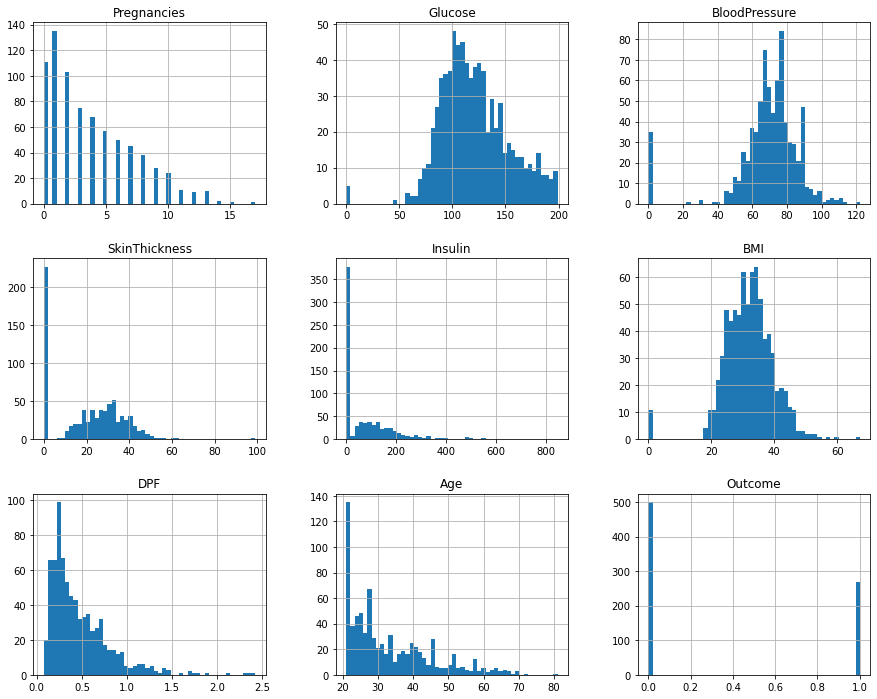

In [9]:
fig, axis = plt.subplots(3,3, figsize = (15,12))
data.hist(bins = 50, ax = axis)

As observed in the histogram charts, the data's distribution reveals that glucose, BMI, and blood pressure exhibit nearly normal distributions.

In [10]:
print((data==0).sum())

Pregnancies      111
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
DPF                0
Age                0
Outcome          500
dtype: int64


There are numerous zeros in the data columns, with some, like insulin and BMI, being invalid as they cannot be zero. This suggests that zero values might have been used in place of NaN values. Consequently, we need to replace all the zeros in these columns with NaN values.

In [11]:
data[['Glucose','BloodPressure','SkinThickness',
      'Insulin','BMI']] = data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [12]:
data.isnull().sum()

Pregnancies        0
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
DPF                0
Age                0
Outcome            0
dtype: int64

In [13]:
Missing_value = pd.DataFrame({"Count":data.isnull().sum(),
                              "Percentage":round(100*data.isnull().sum()/data.count().max(), 2)})

Missing_value.T

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  \
Count               0.0     5.00          35.00         227.00    374.0   
Percentage          0.0     0.65           4.56          29.56     48.7   

              BMI  DPF  Age  Outcome  
Count       11.00  0.0  0.0      0.0  
Percentage   1.43  0.0  0.0      0.0

In [14]:
data_copy = data.copy(deep=True)

In [15]:
data_copy=data_copy.dropna(thresh=0.7*len(data_copy.columns))  
#only keep rows with atleast 75% non-NaN values

In [16]:
data_copy.shape
#removed 35 rows

(733, 9)

We replace the remaining missing data values in each column with the average value of the data (mean) for that specific column. Additionally, to enhance accuracy, we compute the average of the output data based on the class labels (Outcome).

In [17]:
for i in data_copy.columns[data_copy.isnull().any(axis=0)]:     
    data_copy[i] = data_copy.groupby(["Outcome"])[i].transform(lambda x: x.fillna(x.mean()))

### Manage Outlier Data with IQR method

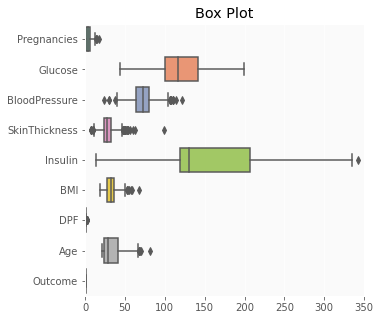

In [18]:
plt.style.use('ggplot') # Using ggplot2 style visuals 

f, ax = plt.subplots(figsize=(5, 5))

ax.set_facecolor('#fafafa')
ax.set(xlim=(-.05, 350))
plt.title("Box Plot")

pd.DataFrame.iteritems = pd.DataFrame.items

ax = sns.boxplot(data = data_copy, 
  orient = 'h', 
  palette = 'Set2')

In [19]:
#IQR range

Q1  = pd.DataFrame()
Q3  =   pd.DataFrame()
IQR =  pd.DataFrame()
UpperLimit =  pd.DataFrame()
LowerLimit =  pd.DataFrame()
Outlier_UpperLimit =  pd.DataFrame(index=[1,2,3,4])
Outlier_LowerLimit =  pd.DataFrame(index=[1,2,3,4])

columns = data_copy.columns[0:-1]

for i in columns:
    Q1[i] = [data_copy[i].quantile(0.25)]
    Q3[i]=  [data_copy[i].quantile(0.75)]
    IQR[i] = [Q3[i][0]-Q1[i][0]]
    UpperLimit[i] = [Q3[i][0]+1.5*IQR[i][0]]
    LowerLimit[i] = [Q1[i][0]-1.5*IQR[i][0]]

In [20]:
df = pd.concat([Q1,Q3,IQR,UpperLimit,LowerLimit])
df.index = ["Q1","Q3","IQR","UpperLimit","LowerLimit"]
dft = df.T
dft

Q1          Q3        IQR  UpperLimit  LowerLimit
Pregnancies      1.000    6.000000   5.000000   13.500000   -6.500000
Glucose        100.000  142.000000  42.000000  205.000000   37.000000
BloodPressure   64.000   80.000000  16.000000  104.000000   40.000000
SkinThickness   24.000   33.000000   9.000000   46.500000   10.500000
Insulin        119.000  206.846154  87.846154  338.615385  -12.769231
BMI             27.500   36.600000   9.100000   50.250000   13.850000
DPF              0.245    0.629000   0.384000    1.205000   -0.331000
Age             24.000   41.000000  17.000000   66.500000   -1.500000

In [21]:
## upper outliers

upoutliers = []
print('Upper Limit Outlier: ', '\n')
for i in columns:
    upoutliers = np.array(data_copy[data_copy[i]>dft['UpperLimit'][i]][i])
    print('{} Outliers: {}'.format(i, upoutliers))

Upper Limit Outlier:  

Pregnancies Outliers: [15 17 14 14]
Glucose Outliers: []
BloodPressure Outliers: [110. 108. 122. 110. 108. 110. 106. 106. 106. 114.]
SkinThickness Outliers: [47. 47. 60. 54. 51. 56. 50. 54. 50. 52. 48. 49. 63. 48. 52. 49. 47. 99.
 50. 47. 48. 49. 48.]
Insulin Outliers: [543. 846. 342. 495. 485. 495. 478. 744. 370. 680. 402. 375. 545. 360.
 465. 415. 579. 474. 480. 600. 440. 540. 480. 387. 392. 510.]
BMI Outliers: [53.2 55.  67.1 52.3 52.9 59.4 57.3]
DPF Outliers: [2.288 1.441 1.39  1.893 1.781 1.222 1.4   1.321 1.224 2.329 1.318 1.213
 1.353 1.224 1.391 1.476 2.137 1.731 1.268 1.6   2.42  1.251 1.699 1.258
 1.282 1.698 1.461 1.292 1.394]
Age Outliers: [69 67 81 67 67 70 68]


In [22]:
## lower outliers

lowoutliers = []
print('Lower Limit Outlier: ', '\n')
for i in columns:
    lowoutliers = np.array(data_copy[data_copy[i]<dft['LowerLimit'][i]][i])
    print('{} Outliers: {}'.format(i, lowoutliers))

Lower Limit Outlier:  

Pregnancies Outliers: []
Glucose Outliers: []
BloodPressure Outliers: [30. 30. 24. 38.]
SkinThickness Outliers: [10.  7. 10. 10.  8.  8. 10.  7. 10.]
Insulin Outliers: []
BMI Outliers: []
DPF Outliers: []
Age Outliers: []


In [23]:
## Data capping NOT data Deletion

columns_cap = ["Insulin","SkinThickness","DPF","Pregnancies","BloodPressure","BMI","Age"]

def Cap_Outliers(dff,column):
    for i in column:
        print('Working on column: {}'.format(i))
        dff[i] = np.where(dff[i]>dft["UpperLimit"][i],dft["UpperLimit"][i],
                            np.where(dff[i]<dft["LowerLimit"][i],dft["LowerLimit"][i],dff[i]))
    return dff

Cap_Outliers(data_copy,columns_cap)

Working on column: Insulin
Working on column: SkinThickness
Working on column: DPF
Working on column: Pregnancies
Working on column: BloodPressure
Working on column: BMI
Working on column: Age


Pregnancies  Glucose  BloodPressure  SkinThickness     Insulin   BMI  \
0            6.0    148.0           72.0           35.0  206.846154  33.6   
1            1.0     85.0           66.0           29.0  130.287879  26.6   
2            8.0    183.0           64.0           33.0  206.846154  23.3   
3            1.0     89.0           66.0           23.0   94.000000  28.1   
4            0.0    137.0           40.0           35.0  168.000000  43.1   
..           ...      ...            ...            ...         ...   ...   
763         10.0    101.0           76.0           46.5  180.000000  32.9   
764          2.0    122.0           70.0           27.0  130.287879  36.8   
765          5.0    121.0           72.0           23.0  112.000000  26.2   
766          1.0    126.0           60.0           33.0  206.846154  30.1   
767          1.0     93.0           70.0           31.0  130.287879  30.4   

       DPF   Age  Outcome  
0    0.627  50.0        1  
1    0.351  31.0        0  
2    0.672  32.0        1  
3    0.167  21.0        0  
4    1.205  33.0        1  
..     ...   ...      ...  
763  0.171  63.0        0  
764  0.340  27.0        0  
765  0.245  30.0        0  
766  0.349  47.0        1  
767  0.315  23.0        0  

[733 rows x 9 columns]

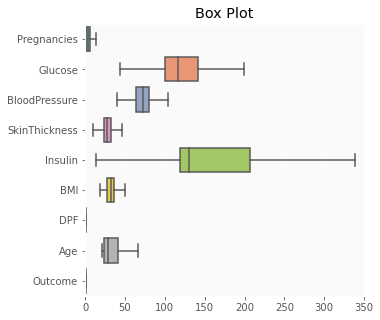

In [24]:
plt.style.use('ggplot') 

f, ax = plt.subplots(figsize=(5, 5))

ax.set_facecolor('#fafafa')
ax.set(xlim=(-.05, 350))
plt.title("Box Plot")
ax = sns.boxplot(data = data_copy, 
  orient = 'h', 
  palette = 'Set2')

## No more outliers

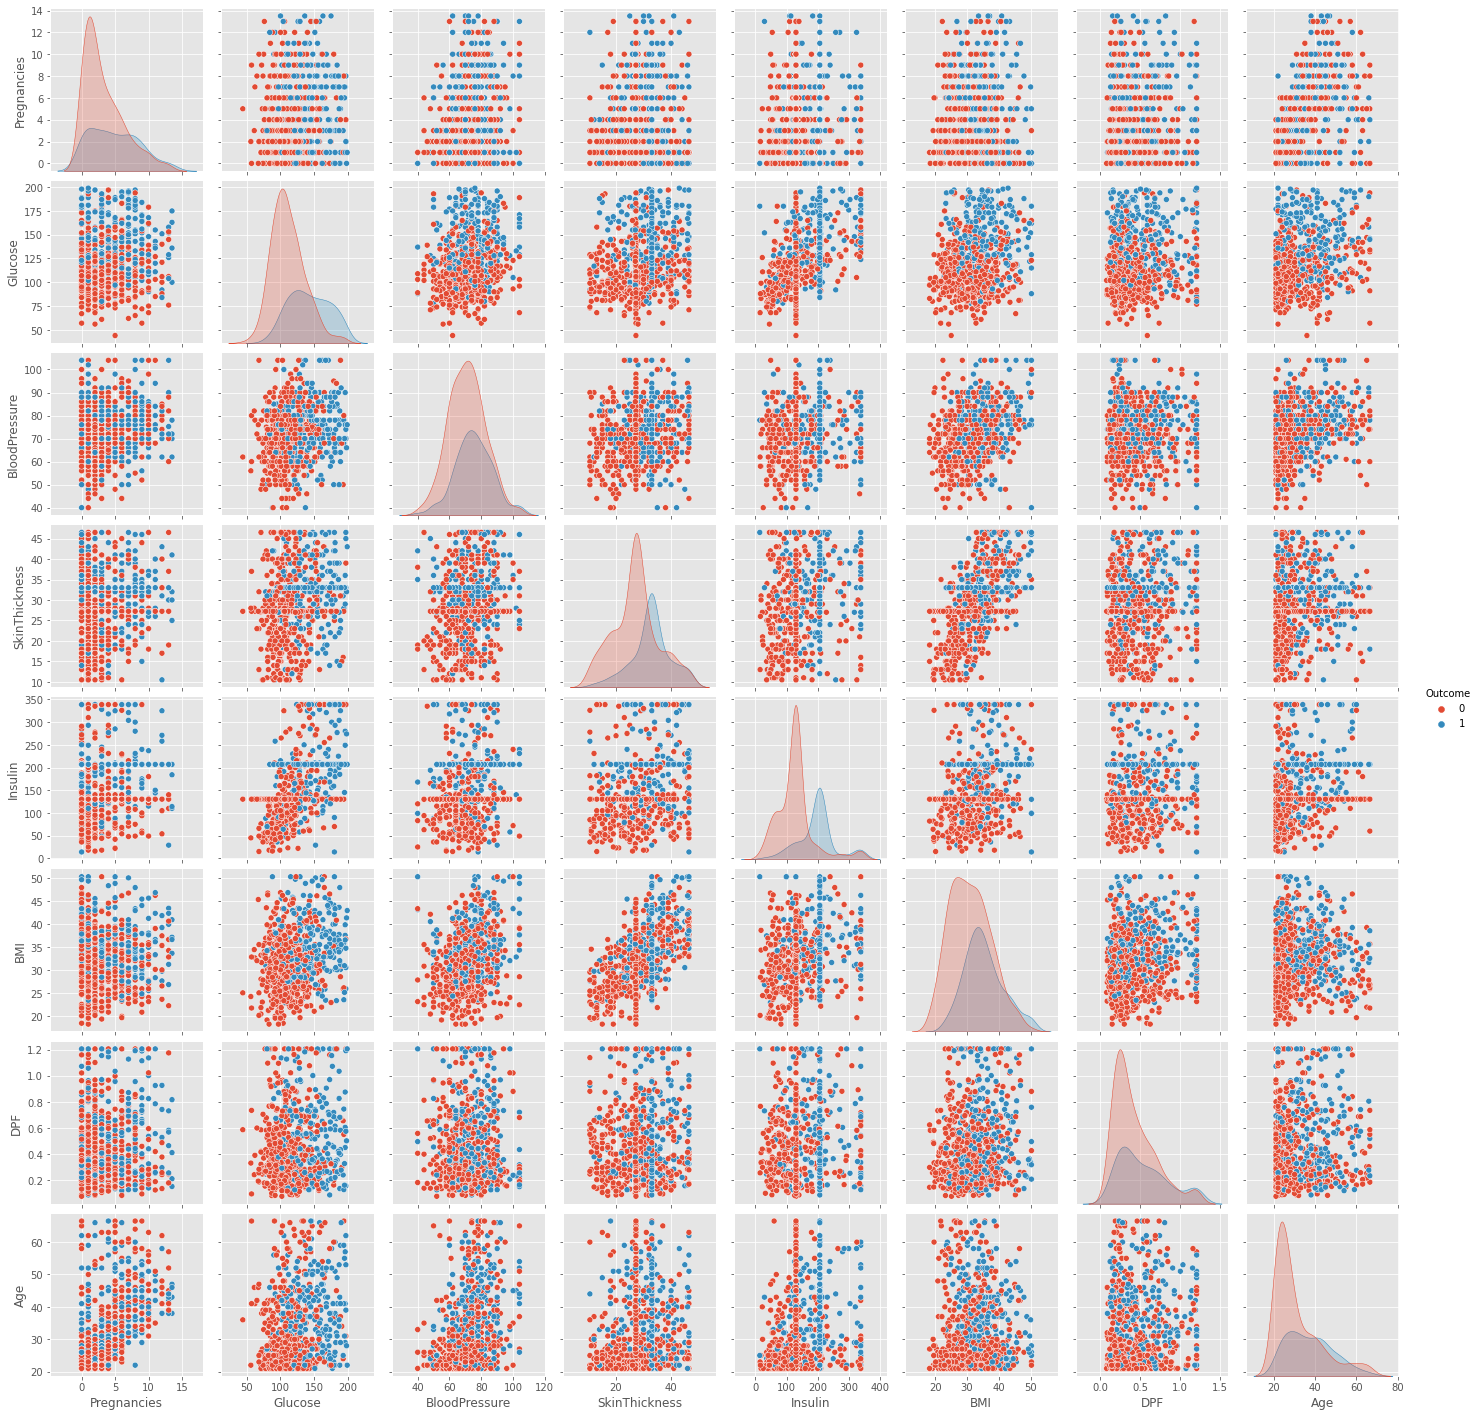

In [25]:
sns.pairplot(data_copy, hue = 'Outcome')

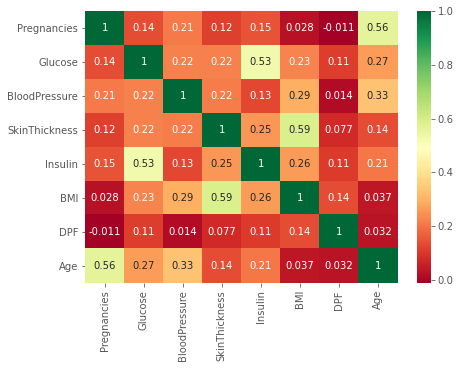

In [26]:
## heatmap for correlation

sns.heatmap(data_copy[data_copy.columns[:8]].corr(),annot=True,cmap='RdYlGn')
fig=plt.gcf()
fig.set_size_inches(7,5)
plt.show()

[Text(0.5, 1.0, 'Kendall correlation')]

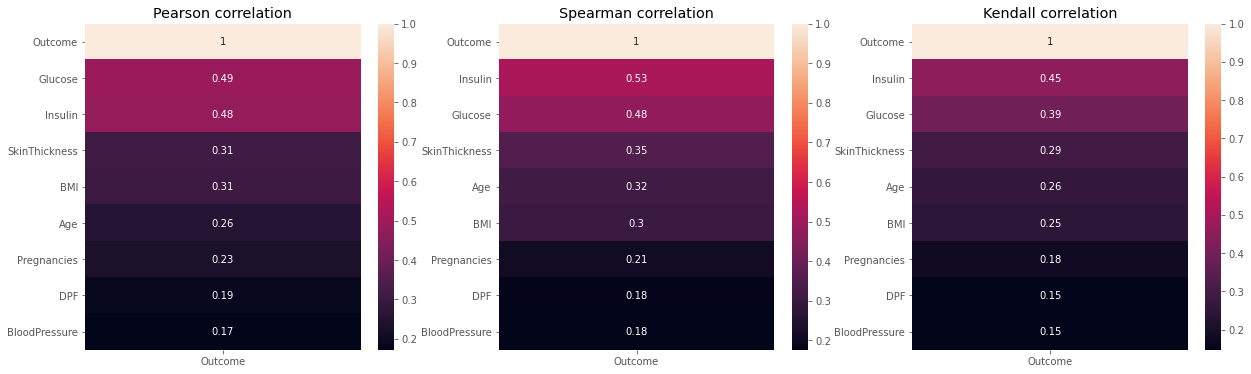

In [27]:
fig, ax = plt.subplots(1,3, figsize=(21, 6))

corr1 = data_copy.corr('pearson')[['Outcome']].sort_values(by='Outcome', ascending=False)
corr2 = data_copy.corr('spearman')[['Outcome']].sort_values(by='Outcome', ascending=False)
corr3 = data_copy.corr('kendall')[['Outcome']].sort_values(by='Outcome', ascending=False)

sns.heatmap(corr1, ax=ax[0], annot=True).set(title='Pearson correlation')
sns.heatmap(corr2, ax=ax[1], annot=True).set(title='Spearman correlation')
sns.heatmap(corr3, ax=ax[2], annot=True).set(title='Kendall correlation')

In [28]:
data_copy.to_csv("data_cln.csv",index=False)

## Model preparation

In [29]:
data_cln = pd.read_csv('data_cln.csv')
x = data_cln.drop(columns = 'Outcome')
y = data_cln['Outcome']

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=100)

In [31]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

586
147
586
147


In [32]:
## Scaling data
scaler = StandardScaler()
scaler.fit(x_train)

x_train_ = scaler.transform(x_train)
x_test_ = scaler.transform(x_test)

### Logistic Regression

In [33]:
lr = LogisticRegression()
lr.fit(x_train_, y_train)

LogisticRegression()

In [34]:
y_pred_lr = lr.predict(x_test_)

Classification report is: 
               precision    recall  f1-score   support

           0       0.76      0.90      0.82        87
           1       0.80      0.58      0.67        60

    accuracy                           0.77       147
   macro avg       0.78      0.74      0.75       147
weighted avg       0.77      0.77      0.76       147

Training score: 
 80.71672354948805
Accuracy score:  76.87074829931973 %
Confusion Matrix: 



Text(0.5, 1.0, 'Logistic Regression')

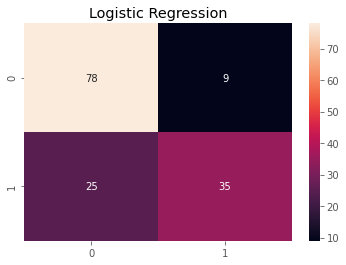

In [35]:
print('Classification report is: \n', classification_report(y_test, y_pred_lr))
cm = confusion_matrix(y_test, y_pred_lr)

print('Training score: \n', lr.score(x_train_, y_train)*100)
print('Accuracy score: ', accuracy_score(y_test, y_pred_lr)*100, '%')

print('Confusion Matrix: \n')
sns.heatmap(cm, annot = True, fmt = 'd').set_title('Logistic Regression')

In [36]:
## K-fold cross validation

X = np.concatenate((x_train_ ,x_test_), axis=0) 
Y = np.concatenate((y_train, y_test))
scores = cross_val_score(lr, X, Y, cv=5, scoring = 'accuracy')
scores.mean()

0.8021526418786692

## K- Nearest Neighbors

In [37]:
knn = KNeighborsClassifier(n_neighbors = 9)

knn.fit(x_train_, y_train)

KNeighborsClassifier(n_neighbors=9)

In [38]:
y_pred_knn = knn.predict(x_test_)

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Classification report is: 
               precision    recall  f1-score   support

           0       0.76      0.92      0.83        87
           1       0.83      0.58      0.69        60

    accuracy                           0.78       147
   macro avg       0.80      0.75      0.76       147
weighted avg       0.79      0.78      0.77       147

Training score: 
 87.54266211604096
Accuracy score:  78.2312925170068 %
Confusion Matrix: 



C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Text(0.5, 1.0, 'KNN')

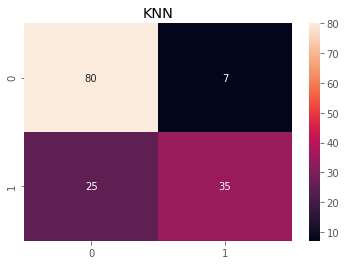

In [39]:
print('Classification report is: \n', classification_report(y_test, y_pred_knn))
cm = confusion_matrix(y_test, y_pred_knn)

print('Training score: \n', knn.score(x_train_, y_train)*100)
print('Accuracy score: ', accuracy_score(y_test, y_pred_knn)*100, '%')

print('Confusion Matrix: \n')
sns.heatmap(cm, annot = True, fmt = 'd').set_title('KNN')

In [40]:
## K-fold cross validation

X = np.concatenate((x_train_ ,x_test_), axis=0) 
Y = np.concatenate((y_train, y_test))
scores = cross_val_score(knn, X, Y, cv=5, scoring = 'accuracy')
scores.mean()

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

0.8267076693691175

## SVM (SVC)

In [41]:
svc = SVC()
svc.fit(x_train_, y_train)

SVC()

In [42]:
y_pred_svc = svc.predict(x_test_)

Classification report is: 
               precision    recall  f1-score   support

           0       0.75      0.92      0.83        87
           1       0.83      0.57      0.67        60

    accuracy                           0.78       147
   macro avg       0.79      0.74      0.75       147
weighted avg       0.79      0.78      0.77       147

Training score: 
 89.93174061433447
Accuracy score:  77.55102040816327 %
Confusion Matrix: 



Text(0.5, 1.0, 'SVC')

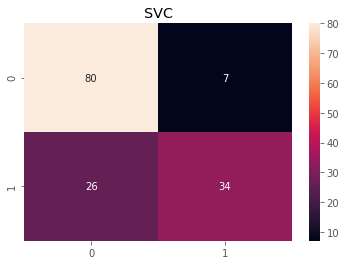

In [43]:
print('Classification report is: \n', classification_report(y_test, y_pred_svc))
cm = confusion_matrix(y_test, y_pred_svc)

print('Training score: \n', svc.score(x_train_, y_train)*100)
print('Accuracy score: ', accuracy_score(y_test, y_pred_svc)*100, '%')

print('Confusion Matrix: \n')
sns.heatmap(cm, annot = True, fmt = 'd').set_title('SVC')

In [44]:
## K-fold cross validation

X = np.concatenate((x_train_ ,x_test_), axis=0) 
Y = np.concatenate((y_train, y_test))
scores = cross_val_score(svc, X, Y, cv=5, scoring = 'accuracy')
scores.mean()

0.8348616158792284

## Naive Bayes

In [45]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(x_train_, y_train)

GaussianNB()

In [46]:
y_pred_gnb = gnb.predict(x_test_)

Classification report is: 
               precision    recall  f1-score   support

           0       0.79      0.82      0.80        87
           1       0.72      0.68      0.70        60

    accuracy                           0.76       147
   macro avg       0.75      0.75      0.75       147
weighted avg       0.76      0.76      0.76       147

Training score: 
 81.05802047781569
Accuracy score:  76.19047619047619 %
Confusion Matrix: 



Text(0.5, 1.0, 'Naive Bayes')

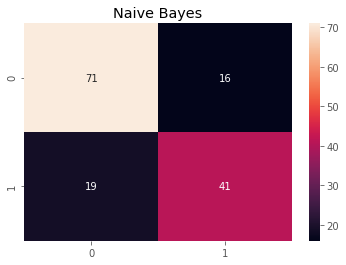

In [47]:
print('Classification report is: \n', classification_report(y_test, y_pred_gnb))
cm = confusion_matrix(y_test, y_pred_gnb)

print('Training score: \n', gnb.score(x_train_, y_train)*100)
print('Accuracy score: ', accuracy_score(y_test, y_pred_gnb)*100, '%')

print('Confusion Matrix: \n')
sns.heatmap(cm, annot = True, fmt = 'd').set_title('Naive Bayes')

In [48]:
## K-fold cross validation

X = np.concatenate((x_train_ ,x_test_), axis=0) 
Y = np.concatenate((y_train, y_test))
scores = cross_val_score(gnb, X, Y, cv=5, scoring = 'accuracy')
scores.mean()

0.7926008759668252

## Decision Tree Classifer

In [49]:
dtree = DecisionTreeClassifier(max_depth = 6, random_state = 123, criterion = 'entropy')
dtree.fit(x_train_, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=123)

In [50]:
y_pred_dtree=dtree.predict(x_test_)

Classification report is: 
               precision    recall  f1-score   support

           0       0.82      0.93      0.87        87
           1       0.88      0.70      0.78        60

    accuracy                           0.84       147
   macro avg       0.85      0.82      0.82       147
weighted avg       0.84      0.84      0.83       147

Training score: 
 95.39249146757679
Accuracy score:  83.6734693877551 %
Confusion Matrix: 



Text(0.5, 1.0, 'Decision Trees')

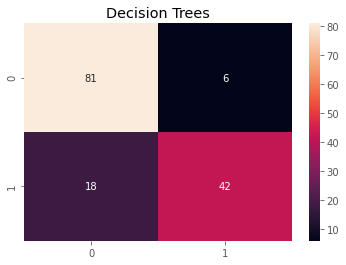

In [51]:
print('Classification report is: \n', classification_report(y_test, y_pred_dtree))
cm = confusion_matrix(y_test, y_pred_dtree)

print('Training score: \n', dtree.score(x_train_, y_train)*100)
print('Accuracy score: ', accuracy_score(y_test, y_pred_dtree)*100, '%')

print('Confusion Matrix: \n')
sns.heatmap(cm, annot = True, fmt = 'd').set_title('Decision Trees')

In [52]:
## K-fold cross validation

X = np.concatenate((x_train_ ,x_test_), axis=0) 
Y = np.concatenate((y_train, y_test))
scores = cross_val_score(dtree, X, Y, cv=5, scoring = 'accuracy')
scores.mean()

0.8471810642065046

## Random Forest Classifier

In [53]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(x_train_, y_train)

RandomForestClassifier()

In [54]:
y_pred_rfc=rfc.predict(x_test_)

Classification report is: 
               precision    recall  f1-score   support

           0       0.84      0.95      0.89        87
           1       0.92      0.73      0.81        60

    accuracy                           0.86       147
   macro avg       0.88      0.84      0.85       147
weighted avg       0.87      0.86      0.86       147

Training score: 
 100.0
Accuracy score:  86.39455782312925 %
Confusion Matrix: 



Text(0.5, 1.0, 'Random Forest')

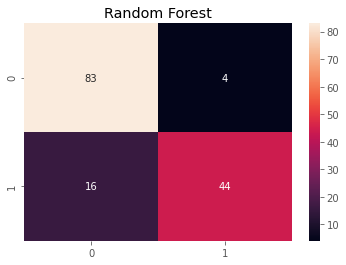

In [55]:
print('Classification report is: \n', classification_report(y_test, y_pred_rfc))
cm = confusion_matrix(y_test, y_pred_rfc)

print('Training score: \n', rfc.score(x_train_, y_train)*100)
print('Accuracy score: ', accuracy_score(y_test, y_pred_rfc)*100, '%')

print('Confusion Matrix: \n')
sns.heatmap(cm, annot = True, fmt = 'd').set_title('Random Forest')

In [56]:
## K-fold cross validation

X = np.concatenate((x_train_ ,x_test_), axis=0) 
Y = np.concatenate((y_train, y_test))
scores = cross_val_score(rfc, X, Y, cv=5, scoring = 'accuracy')
scores.mean()

0.8703382722952193

## AdaBoostClassifier

In [57]:
from sklearn.ensemble import AdaBoostClassifier
adb = AdaBoostClassifier(base_estimator = None)
adb.fit(x_train_, y_train)

AdaBoostClassifier()

In [58]:
y_pred_adb=adb.predict(x_test_)

Classification report is: 
               precision    recall  f1-score   support

           0       0.86      0.91      0.88        87
           1       0.85      0.78      0.82        60

    accuracy                           0.86       147
   macro avg       0.86      0.85      0.85       147
weighted avg       0.86      0.86      0.86       147

Training score: 
 92.15017064846417
Accuracy score:  85.71428571428571 %
Confusion Matrix: 



Text(0.5, 1.0, 'AdaBoostClassifier')

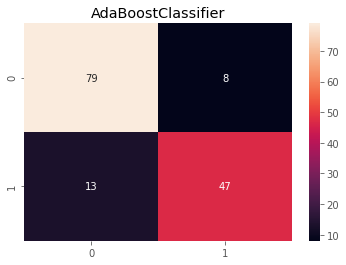

In [59]:
print('Classification report is: \n', classification_report(y_test, y_pred_adb))
cm = confusion_matrix(y_test, y_pred_adb)

print('Training score: \n', adb.score(x_train_, y_train)*100)
print('Accuracy score: ', accuracy_score(y_test, y_pred_adb)*100, '%')

print('Confusion Matrix: \n')
sns.heatmap(cm, annot = True, fmt = 'd').set_title('AdaBoostClassifier')

In [60]:
## K-fold cross validation

X = np.concatenate((x_train_ ,x_test_), axis=0) 
Y = np.concatenate((y_train, y_test))
scores = cross_val_score(adb, X, Y, cv=5, scoring = 'accuracy')
scores.mean()

0.8676544590438915

## Gradient Boosting Classifier

In [61]:
from sklearn.ensemble import GradientBoostingClassifier
gbc=GradientBoostingClassifier()
gbc.fit(x_train_, y_train)

GradientBoostingClassifier()

In [62]:
y_pred_gbc=gbc.predict(x_test_)

Classification report is: 
               precision    recall  f1-score   support

           0       0.83      0.94      0.88        87
           1       0.90      0.72      0.80        60

    accuracy                           0.85       147
   macro avg       0.86      0.83      0.84       147
weighted avg       0.86      0.85      0.85       147

Training score: 
 98.63481228668942
Accuracy score:  85.03401360544217 %
Confusion Matrix: 



Text(0.5, 1.0, 'Gradient Boosting Classifier')

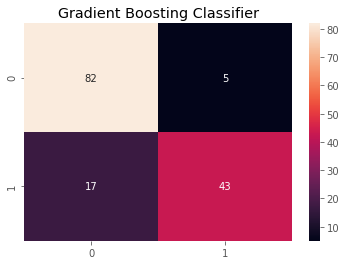

In [63]:
print('Classification report is: \n', classification_report(y_test, y_pred_gbc))
cm = confusion_matrix(y_test, y_pred_gbc)

print('Training score: \n', gbc.score(x_train_, y_train)*100)
print('Accuracy score: ', accuracy_score(y_test, y_pred_gbc)*100, '%')

print('Confusion Matrix: \n')
sns.heatmap(cm, annot = True, fmt = 'd').set_title('Gradient Boosting Classifier')

In [64]:
## K-fold cross validation

X = np.concatenate((x_train_ ,x_test_), axis=0) 
Y = np.concatenate((y_train, y_test))
scores = cross_val_score(gbc, X, Y, cv=5, scoring = 'accuracy')
scores.mean()

0.8812785388127853

## XGBoost Classifier

In [65]:
from xgboost import XGBClassifier

xgb =XGBClassifier(objective ='reg:squarederror', colsample_bytree = 0.4, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xgb.fit(x_train_, y_train)

XGBClassifier(alpha=10, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              objective='reg:squarederror', ...)

In [66]:
y_pred_xgb=xgb.predict(x_test_)

Classification report is: 
               precision    recall  f1-score   support

           0       0.80      0.99      0.89        87
           1       0.97      0.65      0.78        60

    accuracy                           0.85       147
   macro avg       0.89      0.82      0.83       147
weighted avg       0.87      0.85      0.84       147

Training score: 
 88.22525597269625
Accuracy score:  85.03401360544217 %
Confusion Matrix: 



Text(0.5, 1.0, 'XGBoost Classifier')

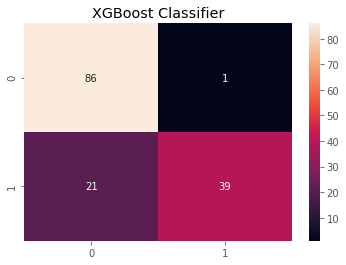

In [67]:
print('Classification report is: \n', classification_report(y_test, y_pred_xgb))
cm = confusion_matrix(y_test, y_pred_xgb)

print('Training score: \n', xgb.score(x_train_, y_train)*100)
print('Accuracy score: ', accuracy_score(y_test, y_pred_xgb)*100, '%')

print('Confusion Matrix: \n')
sns.heatmap(cm, annot = True, fmt = 'd').set_title('XGBoost Classifier')

In [68]:
## K-fold cross validation

X = np.concatenate((x_train_ ,x_test_), axis=0) 
Y = np.concatenate((y_train, y_test))
scores = cross_val_score(xgb, X, Y, cv=5, scoring = 'accuracy')
scores.mean()

0.8608237815674216

## Model Comparision using ROC plot

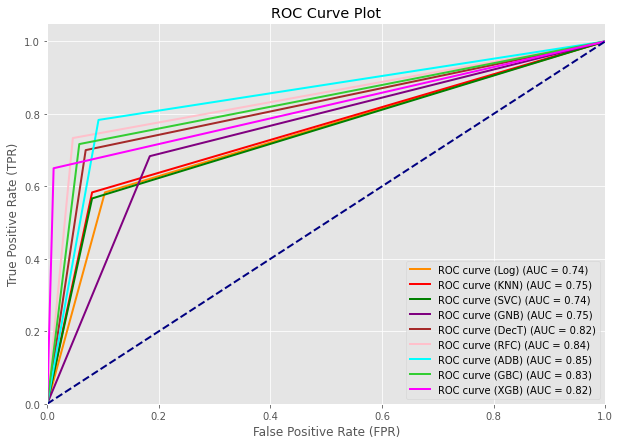

In [69]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_lr)
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred_knn)
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_pred_svc)
fpr4, tpr4, thresholds4 = roc_curve(y_test, y_pred_gnb)
fpr5, tpr5, thresholds5 = roc_curve(y_test, y_pred_dtree)
fpr6, tpr6, thresholds6 = roc_curve(y_test, y_pred_rfc)
fpr7, tpr7, thresholds7 = roc_curve(y_test, y_pred_adb)
fpr8, tpr8, thresholds8 = roc_curve(y_test, y_pred_gbc)
fpr9, tpr9, thresholds9 = roc_curve(y_test, y_pred_xgb)

# calculate area under curve (AUC)
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
roc_auc5 = auc(fpr5, tpr5)
roc_auc6 = auc(fpr6, tpr6)
roc_auc7 = auc(fpr7, tpr7)
roc_auc8 = auc(fpr8, tpr8)
roc_auc9 = auc(fpr9, tpr9)


# plot ROC curve
plt.figure(figsize = (10,7))
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label=f'ROC curve (Log) (AUC = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, color='red', lw=2, label=f'ROC curve (KNN) (AUC = {roc_auc2:.2f})')
plt.plot(fpr3, tpr3, color='green', lw=2, label=f'ROC curve (SVC) (AUC = {roc_auc3:.2f})')
plt.plot(fpr4, tpr4, color='purple', lw=2, label=f'ROC curve (GNB) (AUC = {roc_auc4:.2f})')
plt.plot(fpr5, tpr5, color='brown', lw=2, label=f'ROC curve (DecT) (AUC = {roc_auc5:.2f})')
plt.plot(fpr6, tpr6, color='pink', lw=2, label=f'ROC curve (RFC) (AUC = {roc_auc6:.2f})')
plt.plot(fpr7, tpr7, color='cyan', lw=2, label=f'ROC curve (ADB) (AUC = {roc_auc7:.2f})')
plt.plot(fpr8, tpr8, color='limegreen', lw=2, label=f'ROC curve (GBC) (AUC = {roc_auc8:.2f})')
plt.plot(fpr9, tpr9, color='fuchsia', lw=2, label=f'ROC curve (XGB) (AUC = {roc_auc9:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title("ROC Curve Plot")
plt.legend(loc="lower right")
plt.show()

# Hyperparameter tuning using Optuna

### KNN

In [70]:
import optuna

#from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=100)

# Creating an Objective Function

def objective_knn(trial):
    
    # Define hyperparameters
    param_knn = {'n_neighbors' : trial.suggest_int('n_neighbors', 1, 100)
    ,'weights' : trial.suggest_categorical('weights', ['uniform', 'distance']),
    'metric' : trial.suggest_categorical('metric', ['euclidean', 'manhattan','minkowski']),
    'p' : trial.suggest_int('p', 1, 50),
    'algorithm' : trial.suggest_categorical('algorithm',['auto','ball_tree', 'kd_tree', 'brute']),
    'leaf_size' : trial.suggest_int('leaf_size', 1, 100)}

    # Create and train the model
    knn = KNeighborsClassifier(**param_knn)
    knn.fit(x_train_, y_train)

    # Evaluate the model
    score = cross_val_score(knn, x_train_, y_train, cv=cv, scoring="accuracy").mean()

    return score

In [71]:
study_knn = optuna.create_study(direction='maximize',study_name = "KNN")
study_knn.optimize(objective_knn, n_trials=500)

[I 2023-08-25 01:16:55,208] A new study created in memory with name: KNN
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will b

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[I 2023-08-25 01:16:55,586] Trial 0 finished with value: 0.8436703682057275 and parameters: {'n_neighbors': 61, 'weights': 'uniform', 'metric': 'manhattan', 'p': 48, 'algorithm': 'kd_tree', 'leaf_size': 87}. Best is trial 0 with value: 0.8436703682057275.
[I 2023-08-25 01:16:55,772] Trial 1 finished with value: 0.8334307422559906 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'euclidean', 'p': 10, 'algorithm': 'brute', 'leaf_size': 85}. Best is trial 0 with value: 0.8436703682057275.
[I 2023-08-25 01:16:55,955] Trial 2 finished with value: 0.8228521332554063 and parameters: {'n_neighbors': 40, 'weights': 'distance', 'metric': 'euclidean', 'p': 4, 'algorithm': 'ball_tree', 'leaf_size': 56}. Best is trial 0 with value: 0.8436703682057275.
[I 2023-08-25 01:16:56,144] Trial 3 finished with value: 0.8167036820572765 and parameters: {'n_neighbors': 61, 'weights': 'distance', 'metric': 'euclidean', 'p': 42, 'algorithm': 'kd_tree', 'leaf_size': 19}. Best is trial 0 with v

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[I 2023-08-25 01:17:03,536] Trial 27 finished with value: 0.8474342489772062 and parameters: {'n_neighbors': 44, 'weights': 'distance', 'metric': 'manhattan', 'p': 7, 'algorithm': 'auto', 'leaf_size': 41}. Best is trial 27 with value: 0.8474342489772062.
[I 2023-08-25 01:17:03,782] Trial 28 finished with value: 0.8471011104617183 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'metric': 'minkowski', 'p': 1, 'algorithm': 'auto', 'leaf_size': 40}. Best is trial 27 with value: 0.8474342489772062.
[I 2023-08-25 01:17:04,039] Trial 29 finished with value: 0.8474459380479253 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'metric': 'minkowski', 'p': 1, 'algorithm': 'auto', 'leaf_size': 57}. Best is trial 29 with value: 0.8474459380479253.
[I 2023-08-25 01:17:04,902] Trial 30 finished with value: 0.7979135008766802 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'metric': 'minkowski', 'p': 5, 'algorithm': 'auto', 'leaf_size': 41}. Best is trial 29 with value: 

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[I 2023-08-25 01:17:09,841] Trial 40 finished with value: 0.7760374050263005 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'metric': 'minkowski', 'p': 15, 'algorithm': 'auto', 'leaf_size': 61}. Best is trial 29 with value: 0.8474459380479253.
[I 2023-08-25 01:17:10,022] Trial 41 finished with value: 0.846405610753945 and parameters: {'n_neighbors': 38, 'weights': 'distance', 'metric': 'minkowski', 'p': 1, 'algorithm': 'auto', 'leaf_size': 37}. Best is trial 29 with value: 0.8474459380479253.
[I 2023-08-25 01:17:10,576] Trial 42 finished with value: 0.7920806545879603 and parameters: {'n_neighbors': 36, 'weights': 'distance', 'metric': 'minkowski', 'p': 4, 'algorithm': 'auto', 'leaf_size': 34}. Best is trial 29 with value: 0.8474459380479253.
[I 2023-08-25 01:17:11,138] Trial 43 finished with value: 0.7811922852133257 and parameters: {'n_neighbors': 40, 'weights': 'distance', 'metric': 'minkowski', 'p': 7, 'algorithm': 'auto', 'leaf_size': 45}. Best is trial 29 with value: 

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[I 2023-08-25 01:17:14,312] Trial 50 finished with value: 0.7952659263588545 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'minkowski', 'p': 14, 'algorithm': 'brute', 'leaf_size': 37}. Best is trial 29 with value: 0.8474459380479253.
[I 2023-08-25 01:17:14,497] Trial 51 finished with value: 0.8447048509643483 and parameters: {'n_neighbors': 58, 'weights': 'distance', 'metric': 'minkowski', 'p': 1, 'algorithm': 'auto', 'leaf_size': 50}. Best is trial 29 with value: 0.8474459380479253.
[I 2023-08-25 01:17:15,075] Trial 52 finished with value: 0.7890298071303331 and parameters: {'n_neighbors': 47, 'weights': 'distance', 'metric': 'minkowski', 'p': 4, 'algorithm': 'auto', 'leaf_size': 57}. Best is trial 29 with value: 0.8474459380479253.
[I 2023-08-25 01:17:15,334] Trial 53 finished with value: 0.8303915838690825 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'metric': 'euclidean', 'p': 8, 'algorithm': 'auto', 'leaf_size': 31}. Best is trial 29 with value

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[I 2023-08-25 01:17:16,972] Trial 60 finished with value: 0.8392928112215078 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'manhattan', 'p': 18, 'algorithm': 'ball_tree', 'leaf_size': 13}. Best is trial 59 with value: 0.8549561659848043.
[I 2023-08-25 01:17:17,174] Trial 61 finished with value: 0.8508416130917591 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'manhattan', 'p': 10, 'algorithm': 'ball_tree', 'leaf_size': 22}. Best is trial 59 with value: 0.8549561659848043.
[I 2023-08-25 01:17:17,476] Trial 62 finished with value: 0.8559964932787842 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan', 'p': 10, 'algorithm': 'ball_tree', 'leaf_size': 1}. Best is trial 62 with value: 0.8559964932787842.
[I 2023-08-25 01:17:17,745] Trial 63 finished with value: 0.8549561659848043 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan', 'p': 10, 'algorithm': 'ball_tree', 'leaf_size': 1}. Best is t

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[I 2023-08-25 01:17:22,316] Trial 81 finished with value: 0.8549561659848043 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan', 'p': 21, 'algorithm': 'ball_tree', 'leaf_size': 1}. Best is trial 62 with value: 0.8559964932787842.
[I 2023-08-25 01:17:22,544] Trial 82 finished with value: 0.8559964932787842 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan', 'p': 16, 'algorithm': 'ball_tree', 'leaf_size': 100}. Best is trial 62 with value: 0.8559964932787842.
[I 2023-08-25 01:17:22,807] Trial 83 finished with value: 0.8508533021624781 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'metric': 'manhattan', 'p': 16, 'algorithm': 'ball_tree', 'leaf_size': 5}. Best is trial 62 with value: 0.8559964932787842.
[I 2023-08-25 01:17:23,007] Trial 84 finished with value: 0.8491408533021624 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'metric': 'manhattan', 'p': 13, 'algorithm': 'ball_tree', 'leaf_size': 96}. Best i

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[I 2023-08-25 01:17:26,469] Trial 98 finished with value: 0.8559964932787842 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan', 'p': 33, 'algorithm': 'brute', 'leaf_size': 11}. Best is trial 62 with value: 0.8559964932787842.
[I 2023-08-25 01:17:26,662] Trial 99 finished with value: 0.837551139684395 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'p': 32, 'algorithm': 'brute', 'leaf_size': 13}. Best is trial 62 with value: 0.8559964932787842.
[I 2023-08-25 01:17:26,826] Trial 100 finished with value: 0.8542723553477498 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'manhattan', 'p': 23, 'algorithm': 'brute', 'leaf_size': 10}. Best is trial 62 with value: 0.8559964932787842.
[I 2023-08-25 01:17:26,987] Trial 101 finished with value: 0.8553009935710111 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'p': 40, 'algorithm': 'brute', 'leaf_size': 6}. Best is trial 62 with 

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[I 2023-08-25 01:17:30,462] Trial 117 finished with value: 0.8491408533021624 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'metric': 'manhattan', 'p': 45, 'algorithm': 'ball_tree', 'leaf_size': 18}. Best is trial 62 with value: 0.8559964932787842.
[I 2023-08-25 01:17:30,616] Trial 118 finished with value: 0.8553009935710111 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'p': 25, 'algorithm': 'brute', 'leaf_size': 3}. Best is trial 62 with value: 0.8559964932787842.
[I 2023-08-25 01:17:30,752] Trial 119 finished with value: 0.8433722969023961 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'manhattan', 'p': 30, 'algorithm': 'brute', 'leaf_size': 3}. Best is trial 62 with value: 0.8559964932787842.
[I 2023-08-25 01:17:30,975] Trial 120 finished with value: 0.8495324371712449 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan', 'p': 22, 'algorithm': 'brute', 'leaf_size': 7}. Best is trial 62 

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[I 2023-08-25 01:17:35,442] Trial 146 finished with value: 0.8553009935710111 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'p': 38, 'algorithm': 'brute', 'leaf_size': 26}. Best is trial 62 with value: 0.8559964932787842.
[I 2023-08-25 01:17:35,621] Trial 147 finished with value: 0.8396376388077148 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'p': 26, 'algorithm': 'ball_tree', 'leaf_size': 64}. Best is trial 62 with value: 0.8559964932787842.
[I 2023-08-25 01:17:35,794] Trial 148 finished with value: 0.8511981297486851 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'manhattan', 'p': 35, 'algorithm': 'ball_tree', 'leaf_size': 7}. Best is trial 62 with value: 0.8559964932787842.
[I 2023-08-25 01:17:35,972] Trial 149 finished with value: 0.8549561659848043 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan', 'p': 13, 'algorithm': 'kd_tree', 'leaf_size': 14}. Best is t

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[I 2023-08-25 01:17:38,222] Trial 161 finished with value: 0.8559964932787842 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan', 'p': 38, 'algorithm': 'brute', 'leaf_size': 11}. Best is trial 62 with value: 0.8559964932787842.
[I 2023-08-25 01:17:38,395] Trial 162 finished with value: 0.8508533021624781 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'metric': 'manhattan', 'p': 37, 'algorithm': 'brute', 'leaf_size': 12}. Best is trial 62 with value: 0.8559964932787842.
[I 2023-08-25 01:17:38,543] Trial 163 finished with value: 0.8553009935710111 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'p': 38, 'algorithm': 'brute', 'leaf_size': 15}. Best is trial 62 with value: 0.8559964932787842.
[I 2023-08-25 01:17:38,705] Trial 164 finished with value: 0.8542723553477498 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'manhattan', 'p': 41, 'algorithm': 'brute', 'leaf_size': 8}. Best is trial 62 w

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[I 2023-08-25 01:17:44,677] Trial 192 finished with value: 0.8388836937463471 and parameters: {'n_neighbors': 85, 'weights': 'distance', 'metric': 'manhattan', 'p': 43, 'algorithm': 'brute', 'leaf_size': 91}. Best is trial 62 with value: 0.8559964932787842.
[I 2023-08-25 01:17:45,086] Trial 193 finished with value: 0.8511981297486851 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'manhattan', 'p': 37, 'algorithm': 'brute', 'leaf_size': 11}. Best is trial 62 with value: 0.8559964932787842.
[I 2023-08-25 01:17:45,320] Trial 194 finished with value: 0.8549561659848043 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan', 'p': 40, 'algorithm': 'brute', 'leaf_size': 13}. Best is trial 62 with value: 0.8559964932787842.
[I 2023-08-25 01:17:45,536] Trial 195 finished with value: 0.8518585622443017 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'metric': 'manhattan', 'p': 39, 'algorithm': 'brute', 'leaf_size': 9}. Best is trial 62 w

[I 2023-08-25 01:17:51,958] Trial 224 finished with value: 0.8511981297486851 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'manhattan', 'p': 39, 'algorithm': 'brute', 'leaf_size': 7}. Best is trial 62 with value: 0.8559964932787842.
[I 2023-08-25 01:17:52,170] Trial 225 finished with value: 0.8559964932787842 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan', 'p': 36, 'algorithm': 'brute', 'leaf_size': 15}. Best is trial 62 with value: 0.8559964932787842.
[I 2023-08-25 01:17:52,445] Trial 226 finished with value: 0.8495324371712449 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan', 'p': 34, 'algorithm': 'ball_tree', 'leaf_size': 46}. Best is trial 62 with value: 0.8559964932787842.
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it 

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[I 2023-08-25 01:17:59,237] Trial 253 finished with value: 0.8351315020455874 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'euclidean', 'p': 25, 'algorithm': 'kd_tree', 'leaf_size': 11}. Best is trial 62 with value: 0.8559964932787842.
[I 2023-08-25 01:17:59,487] Trial 254 finished with value: 0.8511981297486851 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'manhattan', 'p': 35, 'algorithm': 'brute', 'leaf_size': 3}. Best is trial 62 with value: 0.8559964932787842.
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid 

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[I 2023-08-25 01:18:04,215] Trial 273 finished with value: 0.8495324371712449 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan', 'p': 26, 'algorithm': 'ball_tree', 'leaf_size': 36}. Best is trial 62 with value: 0.8559964932787842.
[I 2023-08-25 01:18:04,407] Trial 274 finished with value: 0.8542723553477498 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'manhattan', 'p': 9, 'algorithm': 'brute', 'leaf_size': 17}. Best is trial 62 with value: 0.8559964932787842.
[I 2023-08-25 01:18:04,595] Trial 275 finished with value: 0.8549561659848043 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan', 'p': 39, 'algorithm': 'brute', 'leaf_size': 5}. Best is trial 62 with value: 0.8559964932787842.
[I 2023-08-25 01:18:04,819] Trial 276 finished with value: 0.8511981297486851 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'manhattan', 'p': 10, 'algorithm': 'ball_tree', 'leaf_size': 8}. Best is tria

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[I 2023-08-25 01:18:10,126] Trial 293 finished with value: 0.7788077147866745 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'minkowski', 'p': 36, 'algorithm': 'ball_tree', 'leaf_size': 13}. Best is trial 62 with value: 0.8559964932787842.
[I 2023-08-25 01:18:10,328] Trial 294 finished with value: 0.8553009935710111 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'p': 34, 'algorithm': 'brute', 'leaf_size': 6}. Best is trial 62 with value: 0.8559964932787842.
[I 2023-08-25 01:18:10,542] Trial 295 finished with value: 0.8511981297486851 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'manhattan', 'p': 37, 'algorithm': 'brute', 'leaf_size': 11}. Best is trial 62 with value: 0.8559964932787842.
[I 2023-08-25 01:18:10,875] Trial 296 finished with value: 0.8453828170660432 and parameters: {'n_neighbors': 33, 'weights': 'distance', 'metric': 'manhattan', 'p': 12, 'algorithm': 'ball_tree', 'leaf_size': 1}. Best is tri

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[I 2023-08-25 01:18:17,387] Trial 322 finished with value: 0.8512273524254822 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan', 'p': 21, 'algorithm': 'ball_tree', 'leaf_size': 7}. Best is trial 62 with value: 0.8559964932787842.
[I 2023-08-25 01:18:17,543] Trial 323 finished with value: 0.8549561659848043 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan', 'p': 11, 'algorithm': 'brute', 'leaf_size': 3}. Best is trial 62 with value: 0.8559964932787842.
[I 2023-08-25 01:18:17,698] Trial 324 finished with value: 0.8518585622443017 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'metric': 'manhattan', 'p': 39, 'algorithm': 'brute', 'leaf_size': 12}. Best is trial 62 with value: 0.8559964932787842.
[I 2023-08-25 01:18:17,876] Trial 325 finished with value: 0.8511981297486851 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'manhattan', 'p': 34, 'algorithm': 'ball_tree', 'leaf_size': 24}. Best is tri

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
[I 2023-08-25 01:18:18,992] Trial 330 finished with value: 0.8362068965517241 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'manhattan', 'p': 33, 'algorithm': 'brute', 'leaf_size': 18}. Best is trial 62 with value: 0.8559964932787842.
[I 2023-08-25 01:18:19,166] Trial 331 finished with value: 0.8559964932787842 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan', 'p': 18, 'algorithm': 'brute', 'leaf_s

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[I 2023-08-25 01:18:26,419] Trial 359 finished with value: 0.8542723553477498 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'manhattan', 'p': 36, 'algorithm': 'ball_tree', 'leaf_size': 10}. Best is trial 351 with value: 0.8570192869666861.
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` 

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[I 2023-08-25 01:18:31,204] Trial 375 finished with value: 0.8542723553477498 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'manhattan', 'p': 34, 'algorithm': 'kd_tree', 'leaf_size': 15}. Best is trial 351 with value: 0.8570192869666861.
[I 2023-08-25 01:18:31,382] Trial 376 finished with value: 0.8553009935710111 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'p': 35, 'algorithm': 'brute', 'leaf_size': 8}. Best is trial 351 with value: 0.8570192869666861.
[I 2023-08-25 01:18:31,573] Trial 377 finished with value: 0.8512273524254822 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan', 'p': 37, 'algorithm': 'brute', 'leaf_size': 5}. Best is trial 351 with value: 0.8570192869666861.
[I 2023-08-25 01:18:31,840] Trial 378 finished with value: 0.846405610753945 and parameters: {'n_neighbors': 38, 'weights': 'distance', 'metric': 'manhattan', 'p': 25, 'algorithm': 'ball_tree', 'leaf_size': 10}. Best is tri

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[I 2023-08-25 01:18:34,464] Trial 388 finished with value: 0.8338047925189948 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'euclidean', 'p': 16, 'algorithm': 'ball_tree', 'leaf_size': 12}. Best is trial 351 with value: 0.8570192869666861.
[I 2023-08-25 01:18:34,710] Trial 389 finished with value: 0.8518585622443017 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'metric': 'manhattan', 'p': 19, 'algorithm': 'brute', 'leaf_size': 1}. Best is trial 351 with value: 0.8570192869666861.
[I 2023-08-25 01:18:34,920] Trial 390 finished with value: 0.8559964932787842 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan', 'p': 34, 'algorithm': 'brute', 'leaf_size': 16}. Best is trial 351 with value: 0.8570192869666861.
[I 2023-08-25 01:18:35,148] Trial 391 finished with value: 0.8512273524254822 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan', 'p': 38, 'algorithm': 'ball_tree', 'leaf_size': 7}. Best is 

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[I 2023-08-25 01:18:36,902] Trial 399 finished with value: 0.8508533021624781 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'metric': 'manhattan', 'p': 37, 'algorithm': 'kd_tree', 'leaf_size': 14}. Best is trial 351 with value: 0.8570192869666861.
[I 2023-08-25 01:18:37,142] Trial 400 finished with value: 0.8559964932787842 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan', 'p': 42, 'algorithm': 'brute', 'leaf_size': 19}. Best is trial 351 with value: 0.8570192869666861.
[I 2023-08-25 01:18:37,368] Trial 401 finished with value: 0.8495324371712449 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan', 'p': 39, 'algorithm': 'ball_tree', 'leaf_size': 4}. Best is trial 351 with value: 0.8570192869666861.
[I 2023-08-25 01:18:37,534] Trial 402 finished with value: 0.8549561659848043 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan', 'p': 38, 'algorithm': 'brute', 'leaf_size': 7}. Best is tr

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[I 2023-08-25 01:18:47,207] Trial 435 finished with value: 0.8553009935710111 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'p': 12, 'algorithm': 'brute', 'leaf_size': 9}. Best is trial 351 with value: 0.8570192869666861.
[I 2023-08-25 01:18:47,450] Trial 436 finished with value: 0.8559964932787842 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan', 'p': 38, 'algorithm': 'brute', 'leaf_size': 18}. Best is trial 351 with value: 0.8570192869666861.
[I 2023-08-25 01:18:47,866] Trial 437 finished with value: 0.8508416130917591 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'manhattan', 'p': 39, 'algorithm': 'ball_tree', 'leaf_size': 2}. Best is trial 351 with value: 0.8570192869666861.
[I 2023-08-25 01:18:48,068] Trial 438 finished with value: 0.8542723553477498 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'manhattan', 'p': 25, 'algorithm': 'brute', 'leaf_size': 6}. Best is trial

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[I 2023-08-25 01:18:52,387] Trial 456 finished with value: 0.8553009935710111 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'p': 39, 'algorithm': 'ball_tree', 'leaf_size': 12}. Best is trial 351 with value: 0.8570192869666861.
[I 2023-08-25 01:18:52,558] Trial 457 finished with value: 0.8508416130917591 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'manhattan', 'p': 41, 'algorithm': 'brute', 'leaf_size': 8}. Best is trial 351 with value: 0.8570192869666861.
[I 2023-08-25 01:18:52,748] Trial 458 finished with value: 0.8559964932787842 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan', 'p': 18, 'algorithm': 'brute', 'leaf_size': 81}. Best is trial 351 with value: 0.8570192869666861.
[I 2023-08-25 01:18:52,988] Trial 459 finished with value: 0.8447048509643483 and parameters: {'n_neighbors': 49, 'weights': 'distance', 'metric': 'manhattan', 'p': 7, 'algorithm': 'ball_tree', 'leaf_size': 11}. Best is 

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[I 2023-08-25 01:18:55,268] Trial 467 finished with value: 0.8433722969023961 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'manhattan', 'p': 14, 'algorithm': 'brute', 'leaf_size': 8}. Best is trial 351 with value: 0.8570192869666861.
[I 2023-08-25 01:18:55,500] Trial 468 finished with value: 0.8512273524254822 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan', 'p': 15, 'algorithm': 'ball_tree', 'leaf_size': 6}. Best is trial 351 with value: 0.8570192869666861.
[I 2023-08-25 01:18:55,729] Trial 469 finished with value: 0.8511981297486851 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'manhattan', 'p': 40, 'algorithm': 'brute', 'leaf_size': 55}. Best is trial 351 with value: 0.8570192869666861.
[I 2023-08-25 01:18:55,947] Trial 470 finished with value: 0.8508416130917591 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'manhattan', 'p': 36, 'algorithm': 'brute', 'leaf_size': 10}. Best is trial

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

[I 2023-08-25 01:19:01,163] Trial 489 finished with value: 0.848790181180596 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'metric': 'manhattan', 'p': 41, 'algorithm': 'brute', 'leaf_size': 58}. Best is trial 351 with value: 0.8570192869666861.
[I 2023-08-25 01:19:01,416] Trial 490 finished with value: 0.8542723553477498 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'manhattan', 'p': 26, 'algorithm': 'brute', 'leaf_size': 12}. Best is trial 351 with value: 0.8570192869666861.
[I 2023-08-25 01:19:01,769] Trial 491 finished with value: 0.8423085914669782 and parameters: {'n_neighbors': 75, 'weights': 'distance', 'metric': 'manhattan', 'p': 37, 'algorithm': 'ball_tree', 'leaf_size': 3}. Best is trial 351 with value: 0.8570192869666861.
[I 2023-08-25 01:19:02,017] Trial 492 finished with value: 0.8450730566919931 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan', 'p': 21, 'algorithm': 'brute', 'leaf_size': 16}. Best is trial

In [72]:
# Evaluating our Optuna Trial
print("Best trial:", study_knn.best_trial.number)
print("Best accuracy:", study_knn.best_trial.value)
print("Best hyperparameters:", study_knn.best_params)

Best trial: 351
Best accuracy: 0.8570192869666861
Best hyperparameters: {'n_neighbors': 15, 'weights': 'uniform', 'metric': 'manhattan', 'p': 35, 'algorithm': 'brute', 'leaf_size': 11}


C:\Users\rutun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score   support

           0       0.78      0.93      0.85        87
           1       0.86      0.62      0.72        60

    accuracy                           0.80       147
   macro avg       0.82      0.77      0.78       147
weighted avg       0.81      0.80      0.80       147



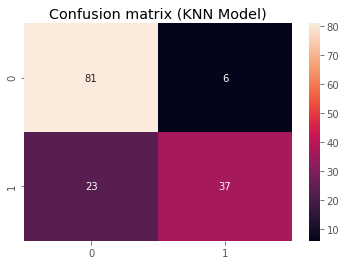

In [73]:
best_param_knn = study_knn.best_params
KNN = KNeighborsClassifier(**best_param_knn).fit(x_train_,y_train)
y_pred_knn = KNN.predict(x_test_)

def display_results(y_test, y_pred, cm_title):
    cm = confusion_matrix(y_test,y_pred)
    sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
    print(classification_report(y_test,y_pred))
    
display_results(y_test, y_pred_knn, cm_title = "Confusion matrix (KNN Model)")

### Logistic Regression

In [74]:
# Creating an Objective Function

def objective_lr(trial):
    
    # Define hyperparameters
    param_logr = {'C' : trial.suggest_float("C", 0.001, 10.0, log=True),
    'solver' : trial.suggest_categorical('solver',["newton-cg", "lbfgs", "liblinear", "sag", "saga"]),
    'max_iter' : trial.suggest_int("max_iter", 1, 10000)
    }

    # Create and train the model
    lr = LogisticRegression(**param_logr,random_state=100)
    lr.fit(x_train_, y_train)

    # Evaluate the model
    score = cross_val_score(lr, x_train_, y_train, cv=cv, scoring="accuracy").mean()

    return score

In [75]:
# Creating and running our optimization

study_lr = optuna.create_study(direction='maximize',study_name = "logr")
study_lr.optimize(objective_lr, n_trials=500)

[I 2023-08-25 01:19:05,329] A new study created in memory with name: logr
[I 2023-08-25 01:19:05,672] Trial 0 finished with value: 0.8013383985973115 and parameters: {'C': 1.3843783343871205, 'solver': 'sag', 'max_iter': 4009}. Best is trial 0 with value: 0.8013383985973115.
[I 2023-08-25 01:19:05,825] Trial 1 finished with value: 0.800999415546464 and parameters: {'C': 9.247004079465194, 'solver': 'liblinear', 'max_iter': 3378}. Best is trial 0 with value: 0.8013383985973115.
[I 2023-08-25 01:19:06,267] Trial 2 finished with value: 0.801677381648159 and parameters: {'C': 3.4174789030775052, 'solver': 'newton-cg', 'max_iter': 2008}. Best is trial 2 with value: 0.801677381648159.
[I 2023-08-25 01:19:06,468] Trial 3 finished with value: 0.8030566919929867 and parameters: {'C': 0.10741527320152755, 'solver': 'saga', 'max_iter': 7375}. Best is trial 3 with value: 0.8030566919929867.
[I 2023-08-25 01:19:06,844] Trial 4 finished with value: 0.7962828755113968 and parameters: {'C': 0.00879681

[I 2023-08-25 01:19:14,220] Trial 40 finished with value: 0.8051198129748686 and parameters: {'C': 0.03139539093295573, 'solver': 'saga', 'max_iter': 9017}. Best is trial 17 with value: 0.8054529514903566.
[I 2023-08-25 01:19:14,400] Trial 41 finished with value: 0.8051198129748686 and parameters: {'C': 0.03130897974548241, 'solver': 'saga', 'max_iter': 6977}. Best is trial 17 with value: 0.8054529514903566.
[I 2023-08-25 01:19:14,579] Trial 42 finished with value: 0.8037463471654004 and parameters: {'C': 0.06957955099325928, 'solver': 'saga', 'max_iter': 7624}. Best is trial 17 with value: 0.8054529514903566.
[I 2023-08-25 01:19:14,765] Trial 43 finished with value: 0.8020280537697253 and parameters: {'C': 0.12446442221006007, 'solver': 'saga', 'max_iter': 6254}. Best is trial 17 with value: 0.8054529514903566.
[I 2023-08-25 01:19:14,947] Trial 44 finished with value: 0.8040970192869668 and parameters: {'C': 0.04281516317253196, 'solver': 'saga', 'max_iter': 8362}. Best is trial 17 wi

[I 2023-08-25 01:19:22,776] Trial 80 finished with value: 0.8030800701344244 and parameters: {'C': 0.015354550000556322, 'solver': 'newton-cg', 'max_iter': 9789}. Best is trial 17 with value: 0.8054529514903566.
[I 2023-08-25 01:19:23,164] Trial 81 finished with value: 0.8051373465809469 and parameters: {'C': 0.02649073704142348, 'solver': 'newton-cg', 'max_iter': 7075}. Best is trial 17 with value: 0.8054529514903566.
[I 2023-08-25 01:19:23,548] Trial 82 finished with value: 0.80479251899474 and parameters: {'C': 0.02896920747403601, 'solver': 'newton-cg', 'max_iter': 8927}. Best is trial 17 with value: 0.8054529514903566.
[I 2023-08-25 01:19:23,930] Trial 83 finished with value: 0.8047983635300995 and parameters: {'C': 0.01843201397032304, 'solver': 'newton-cg', 'max_iter': 6888}. Best is trial 17 with value: 0.8054529514903566.
[I 2023-08-25 01:19:24,297] Trial 84 finished with value: 0.8040970192869668 and parameters: {'C': 0.04000804135447907, 'solver': 'newton-cg', 'max_iter': 93

[I 2023-08-25 01:19:37,578] Trial 119 finished with value: 0.8051198129748686 and parameters: {'C': 0.03428900330297629, 'solver': 'newton-cg', 'max_iter': 6997}. Best is trial 87 with value: 0.8054763296317944.
[I 2023-08-25 01:19:37,874] Trial 120 finished with value: 0.7935417884278197 and parameters: {'C': 0.007852659150661528, 'solver': 'lbfgs', 'max_iter': 807}. Best is trial 87 with value: 0.8054763296317944.
[I 2023-08-25 01:19:38,304] Trial 121 finished with value: 0.8051373465809469 and parameters: {'C': 0.02703249573882102, 'solver': 'newton-cg', 'max_iter': 9988}. Best is trial 87 with value: 0.8054763296317944.
[I 2023-08-25 01:19:38,758] Trial 122 finished with value: 0.805137346580947 and parameters: {'C': 0.024662344282632826, 'solver': 'newton-cg', 'max_iter': 9512}. Best is trial 87 with value: 0.8054763296317944.
[I 2023-08-25 01:19:39,255] Trial 123 finished with value: 0.8041087083576858 and parameters: {'C': 0.017306397339292894, 'solver': 'newton-cg', 'max_iter':

[I 2023-08-25 01:19:50,592] Trial 158 finished with value: 0.8030683810637055 and parameters: {'C': 0.0061548011785558295, 'solver': 'liblinear', 'max_iter': 7137}. Best is trial 157 with value: 0.8057977790765634.
[I 2023-08-25 01:19:50,729] Trial 159 finished with value: 0.8057977790765634 and parameters: {'C': 0.00929677944374721, 'solver': 'liblinear', 'max_iter': 7241}. Best is trial 157 with value: 0.8057977790765634.
[I 2023-08-25 01:19:50,862] Trial 160 finished with value: 0.805113968439509 and parameters: {'C': 0.007586569925652084, 'solver': 'liblinear', 'max_iter': 7232}. Best is trial 157 with value: 0.8057977790765634.
[I 2023-08-25 01:19:50,984] Trial 161 finished with value: 0.8057977790765634 and parameters: {'C': 0.009287036837063882, 'solver': 'liblinear', 'max_iter': 6966}. Best is trial 157 with value: 0.8057977790765634.
[I 2023-08-25 01:19:51,111] Trial 162 finished with value: 0.805113968439509 and parameters: {'C': 0.009023998516617225, 'solver': 'liblinear', '

[I 2023-08-25 01:19:55,722] Trial 197 finished with value: 0.805113968439509 and parameters: {'C': 0.008979570043086037, 'solver': 'liblinear', 'max_iter': 7068}. Best is trial 166 with value: 0.8061367621274107.
[I 2023-08-25 01:19:55,850] Trial 198 finished with value: 0.8017241379310345 and parameters: {'C': 0.004248787447899649, 'solver': 'liblinear', 'max_iter': 6490}. Best is trial 166 with value: 0.8061367621274107.
[I 2023-08-25 01:19:55,979] Trial 199 finished with value: 0.8044301578024546 and parameters: {'C': 0.006881500138367293, 'solver': 'liblinear', 'max_iter': 7222}. Best is trial 166 with value: 0.8061367621274107.
[I 2023-08-25 01:19:56,115] Trial 200 finished with value: 0.8051081239041497 and parameters: {'C': 0.010313959691124095, 'solver': 'liblinear', 'max_iter': 6785}. Best is trial 166 with value: 0.8061367621274107.
[I 2023-08-25 01:19:56,243] Trial 201 finished with value: 0.8054529514903566 and parameters: {'C': 0.012901214171420764, 'solver': 'liblinear', 

[I 2023-08-25 01:20:01,397] Trial 236 finished with value: 0.805113968439509 and parameters: {'C': 0.014996915655369553, 'solver': 'liblinear', 'max_iter': 6058}. Best is trial 166 with value: 0.8061367621274107.
[I 2023-08-25 01:20:01,548] Trial 237 finished with value: 0.8047632963179427 and parameters: {'C': 0.0071105371782808026, 'solver': 'liblinear', 'max_iter': 6524}. Best is trial 166 with value: 0.8061367621274107.
[I 2023-08-25 01:20:01,803] Trial 238 finished with value: 0.8057977790765634 and parameters: {'C': 0.009225126267641326, 'solver': 'liblinear', 'max_iter': 4661}. Best is trial 166 with value: 0.8061367621274107.
[I 2023-08-25 01:20:01,997] Trial 239 finished with value: 0.8051198129748685 and parameters: {'C': 0.008517081226282532, 'solver': 'liblinear', 'max_iter': 4388}. Best is trial 166 with value: 0.8061367621274107.
[I 2023-08-25 01:20:02,218] Trial 240 finished with value: 0.805113968439509 and parameters: {'C': 0.009952776785396002, 'solver': 'liblinear', 

[I 2023-08-25 01:20:08,500] Trial 275 finished with value: 0.8040911747516073 and parameters: {'C': 0.0066730443033569484, 'solver': 'liblinear', 'max_iter': 4140}. Best is trial 166 with value: 0.8061367621274107.
[I 2023-08-25 01:20:08,750] Trial 276 finished with value: 0.805113968439509 and parameters: {'C': 0.007818083025347507, 'solver': 'liblinear', 'max_iter': 5000}. Best is trial 166 with value: 0.8061367621274107.
[I 2023-08-25 01:20:08,931] Trial 277 finished with value: 0.8034190531852718 and parameters: {'C': 0.005456140343024411, 'solver': 'liblinear', 'max_iter': 4847}. Best is trial 166 with value: 0.8061367621274107.
[I 2023-08-25 01:20:09,149] Trial 278 finished with value: 0.8051198129748685 and parameters: {'C': 0.008646157716564443, 'solver': 'liblinear', 'max_iter': 5026}. Best is trial 166 with value: 0.8061367621274107.
[I 2023-08-25 01:20:09,326] Trial 279 finished with value: 0.8024021040327294 and parameters: {'C': 0.004454536794973987, 'solver': 'liblinear',

[I 2023-08-25 01:20:15,261] Trial 314 finished with value: 0.8051081239041497 and parameters: {'C': 0.010341829736040468, 'solver': 'liblinear', 'max_iter': 4431}. Best is trial 166 with value: 0.8061367621274107.
[I 2023-08-25 01:20:15,418] Trial 315 finished with value: 0.8051081239041495 and parameters: {'C': 0.007168175254182831, 'solver': 'liblinear', 'max_iter': 4669}. Best is trial 166 with value: 0.8061367621274107.
[I 2023-08-25 01:20:15,580] Trial 316 finished with value: 0.8034190531852718 and parameters: {'C': 0.005438705199407678, 'solver': 'liblinear', 'max_iter': 5306}. Best is trial 166 with value: 0.8061367621274107.
[I 2023-08-25 01:20:15,789] Trial 317 finished with value: 0.7966218585622442 and parameters: {'C': 0.008617320125105814, 'solver': 'sag', 'max_iter': 4814}. Best is trial 166 with value: 0.8061367621274107.
[I 2023-08-25 01:20:15,949] Trial 318 finished with value: 0.802074810052601 and parameters: {'C': 0.0035108647326508287, 'solver': 'liblinear', 'max_

[I 2023-08-25 01:20:21,757] Trial 353 finished with value: 0.801011104617183 and parameters: {'C': 0.18044107511142396, 'solver': 'liblinear', 'max_iter': 4071}. Best is trial 321 with value: 0.8061426066627702.
[I 2023-08-25 01:20:21,918] Trial 354 finished with value: 0.805447106954997 and parameters: {'C': 0.007287089579009686, 'solver': 'liblinear', 'max_iter': 6983}. Best is trial 321 with value: 0.8061426066627702.
[I 2023-08-25 01:20:22,070] Trial 355 finished with value: 0.8027586206896552 and parameters: {'C': 0.0032935517609796443, 'solver': 'liblinear', 'max_iter': 261}. Best is trial 321 with value: 0.8061426066627702.
[I 2023-08-25 01:20:22,228] Trial 356 finished with value: 0.8013851548801871 and parameters: {'C': 0.00414557363142013, 'solver': 'liblinear', 'max_iter': 5655}. Best is trial 321 with value: 0.8061426066627702.
[I 2023-08-25 01:20:22,401] Trial 357 finished with value: 0.8034132086499125 and parameters: {'C': 0.005864941884287807, 'solver': 'liblinear', 'ma

[I 2023-08-25 01:20:28,453] Trial 392 finished with value: 0.7999999999999998 and parameters: {'C': 0.07505909391551976, 'solver': 'liblinear', 'max_iter': 2745}. Best is trial 321 with value: 0.8061426066627702.
[I 2023-08-25 01:20:28,628] Trial 393 finished with value: 0.805447106954997 and parameters: {'C': 0.012233357160758757, 'solver': 'liblinear', 'max_iter': 7200}. Best is trial 321 with value: 0.8061426066627702.
[I 2023-08-25 01:20:28,872] Trial 394 finished with value: 0.7962828755113968 and parameters: {'C': 0.008560378225698244, 'solver': 'sag', 'max_iter': 2115}. Best is trial 321 with value: 0.8061426066627702.
[I 2023-08-25 01:20:29,045] Trial 395 finished with value: 0.8044301578024546 and parameters: {'C': 0.01376941312809372, 'solver': 'liblinear', 'max_iter': 6792}. Best is trial 321 with value: 0.8061426066627702.
[I 2023-08-25 01:20:29,213] Trial 396 finished with value: 0.8051081239041497 and parameters: {'C': 0.010207730296658774, 'solver': 'liblinear', 'max_ite

[I 2023-08-25 01:20:35,676] Trial 431 finished with value: 0.8017358270017533 and parameters: {'C': 0.0033394782197481536, 'solver': 'liblinear', 'max_iter': 5098}. Best is trial 321 with value: 0.8061426066627702.
[I 2023-08-25 01:20:35,848] Trial 432 finished with value: 0.8051198129748685 and parameters: {'C': 0.008625501834399226, 'solver': 'liblinear', 'max_iter': 3955}. Best is trial 321 with value: 0.8061426066627702.
[I 2023-08-25 01:20:36,031] Trial 433 finished with value: 0.8010052600818236 and parameters: {'C': 0.5323828972603166, 'solver': 'liblinear', 'max_iter': 4897}. Best is trial 321 with value: 0.8061426066627702.
[I 2023-08-25 01:20:36,202] Trial 434 finished with value: 0.805113968439509 and parameters: {'C': 0.0076962147763289575, 'solver': 'liblinear', 'max_iter': 5382}. Best is trial 321 with value: 0.8061426066627702.
[I 2023-08-25 01:20:36,369] Trial 435 finished with value: 0.8010461718293397 and parameters: {'C': 0.004068707233188055, 'solver': 'liblinear', 

[I 2023-08-25 01:20:43,404] Trial 470 finished with value: 0.8054529514903566 and parameters: {'C': 0.010470298912600278, 'solver': 'liblinear', 'max_iter': 1727}. Best is trial 321 with value: 0.8061426066627702.
[I 2023-08-25 01:20:43,726] Trial 471 finished with value: 0.801677381648159 and parameters: {'C': 5.689410831079215, 'solver': 'sag', 'max_iter': 5448}. Best is trial 321 with value: 0.8061426066627702.
[I 2023-08-25 01:20:43,919] Trial 472 finished with value: 0.7999999999999998 and parameters: {'C': 0.09724127358590261, 'solver': 'liblinear', 'max_iter': 5164}. Best is trial 321 with value: 0.8061426066627702.
[I 2023-08-25 01:20:44,094] Trial 473 finished with value: 0.8013851548801871 and parameters: {'C': 0.003722992592160906, 'solver': 'liblinear', 'max_iter': 3819}. Best is trial 321 with value: 0.8061426066627702.
[I 2023-08-25 01:20:44,284] Trial 474 finished with value: 0.8010052600818234 and parameters: {'C': 0.24130829459623884, 'solver': 'liblinear', 'max_iter':

In [76]:
# Evaluating our Optuna Trial
print("Best trial:", study_lr.best_trial.number)
print("Best accuracy:", study_lr.best_trial.value)
print("Best hyperparameters:", study_lr.best_params)

Best trial: 321
Best accuracy: 0.8061426066627702
Best hyperparameters: {'C': 0.008207222073277363, 'solver': 'liblinear', 'max_iter': 4392}


              precision    recall  f1-score   support

           0       0.78      0.84      0.81        87
           1       0.74      0.67      0.70        60

    accuracy                           0.77       147
   macro avg       0.76      0.75      0.76       147
weighted avg       0.77      0.77      0.77       147



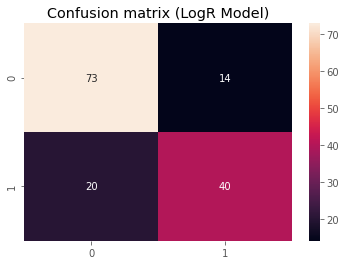

In [77]:
best_param_logr = study_lr.best_params
LR = LogisticRegression(**best_param_logr).fit(x_train_,y_train)
y_pred_lr = LR.predict(x_test_)
    
display_results(y_test, y_pred_lr, cm_title = "Confusion matrix (LogR Model)")

### Decision Trees

In [78]:
# Creating an Objective Function

def objective_dect(trial):
    
    # Define hyperparameters
    param_dect = {'max_depth' : trial.suggest_int("max_depth", 2, 64),
                  'ccp_alpha' :trial.suggest_float('ccp_alpha',0.001, 10.0, log=True),
                  'max_features': trial.suggest_categorical('max_features',['auto', 'sqrt', 'log2']),
                  'min_samples_split' : trial.suggest_int("min_samples_split", 2, 30),
                  'min_samples_leaf' : trial.suggest_int("min_samples_leaf", 1, 30),
                  'criterion' : trial.suggest_categorical("criterion", ["gini", "entropy"])}

    # Create and train the model
    dect = DecisionTreeClassifier(**param_dect,random_state=100)
    dect.fit(x_train, y_train)

    # Evaluate the model
    score = cross_val_score(dect, x_train_, y_train, cv=cv, scoring="accuracy").mean()

    return score

In [79]:
# Creating and running our optimization

study_dect = optuna.create_study(direction='maximize',study_name = "Dect")
study_dect.optimize(objective_dect, n_trials=500)

[I 2023-08-25 01:20:49,711] A new study created in memory with name: Dect
[I 2023-08-25 01:20:49,874] Trial 0 finished with value: 0.6722852133255407 and parameters: {'max_depth': 62, 'ccp_alpha': 1.4120435603404873, 'max_features': 'auto', 'min_samples_split': 13, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 0 with value: 0.6722852133255407.
[I 2023-08-25 01:20:49,998] Trial 1 finished with value: 0.8422559906487433 and parameters: {'max_depth': 20, 'ccp_alpha': 0.0012701922661983332, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 14, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8422559906487433.
[I 2023-08-25 01:20:50,115] Trial 2 finished with value: 0.6722852133255407 and parameters: {'max_depth': 21, 'ccp_alpha': 3.1739151183867143, 'max_features': 'log2', 'min_samples_split': 10, 'min_samples_leaf': 14, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8422559906487433.
[I 2023-08-25 01:20:50,223] Trial 3 finished with value: 0.67

[I 2023-08-25 01:20:53,563] Trial 29 finished with value: 0.8337931034482757 and parameters: {'max_depth': 62, 'ccp_alpha': 0.035004705339542676, 'max_features': 'auto', 'min_samples_split': 12, 'min_samples_leaf': 4, 'criterion': 'gini'}. Best is trial 18 with value: 0.8634833430742256.
[I 2023-08-25 01:20:53,696] Trial 30 finished with value: 0.8440561075394506 and parameters: {'max_depth': 53, 'ccp_alpha': 0.008316983972916605, 'max_features': 'auto', 'min_samples_split': 17, 'min_samples_leaf': 9, 'criterion': 'gini'}. Best is trial 18 with value: 0.8634833430742256.
[I 2023-08-25 01:20:53,861] Trial 31 finished with value: 0.8515020455873759 and parameters: {'max_depth': 43, 'ccp_alpha': 0.003533677780383825, 'max_features': 'log2', 'min_samples_split': 20, 'min_samples_leaf': 14, 'criterion': 'gini'}. Best is trial 18 with value: 0.8634833430742256.
[I 2023-08-25 01:20:53,999] Trial 32 finished with value: 0.8570192869666862 and parameters: {'max_depth': 31, 'ccp_alpha': 0.008400

[I 2023-08-25 01:20:57,558] Trial 58 finished with value: 0.8555873758036237 and parameters: {'max_depth': 64, 'ccp_alpha': 0.0010247684873196331, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 18, 'criterion': 'entropy'}. Best is trial 45 with value: 0.8689596727060198.
[I 2023-08-25 01:20:57,695] Trial 59 finished with value: 0.8710052600818236 and parameters: {'max_depth': 56, 'ccp_alpha': 0.00287211704722268, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 15, 'criterion': 'entropy'}. Best is trial 59 with value: 0.8710052600818236.
[I 2023-08-25 01:20:57,828] Trial 60 finished with value: 0.8682700175336062 and parameters: {'max_depth': 58, 'ccp_alpha': 0.0031031859416310206, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 16, 'criterion': 'entropy'}. Best is trial 59 with value: 0.8710052600818236.
[I 2023-08-25 01:20:57,966] Trial 61 finished with value: 0.8682700175336062 and parameters: {'max_depth': 57, 'ccp_alpha':

[I 2023-08-25 01:21:01,696] Trial 87 finished with value: 0.8716949152542374 and parameters: {'max_depth': 54, 'ccp_alpha': 0.0025440568481971877, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 15, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:01,838] Trial 88 finished with value: 0.8716949152542374 and parameters: {'max_depth': 49, 'ccp_alpha': 0.0025633876593260407, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 15, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:01,977] Trial 89 finished with value: 0.8716949152542374 and parameters: {'max_depth': 49, 'ccp_alpha': 0.002642535606580881, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 15, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:02,114] Trial 90 finished with value: 0.8703272939801288 and parameters: {'max_depth': 49, 'ccp_alpha'

[I 2023-08-25 01:21:05,764] Trial 115 finished with value: 0.8388603156049094 and parameters: {'max_depth': 50, 'ccp_alpha': 0.0015592276056922145, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 27, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:05,900] Trial 116 finished with value: 0.8648451198129748 and parameters: {'max_depth': 46, 'ccp_alpha': 0.0019223087849441012, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 13, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:06,044] Trial 117 finished with value: 0.86895967270602 and parameters: {'max_depth': 49, 'ccp_alpha': 0.0011371231883260495, 'max_features': 'log2', 'min_samples_split': 3, 'min_samples_leaf': 16, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:06,186] Trial 118 finished with value: 0.8610753945061369 and parameters: {'max_depth': 52, 'ccp_alp

[I 2023-08-25 01:21:09,864] Trial 143 finished with value: 0.8710052600818236 and parameters: {'max_depth': 43, 'ccp_alpha': 0.0030647734858315983, 'max_features': 'log2', 'min_samples_split': 3, 'min_samples_leaf': 15, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:10,007] Trial 144 finished with value: 0.8610753945061369 and parameters: {'max_depth': 6, 'ccp_alpha': 0.0013399662775024903, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 17, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:10,149] Trial 145 finished with value: 0.8689596727060198 and parameters: {'max_depth': 46, 'ccp_alpha': 0.0024227451708053807, 'max_features': 'log2', 'min_samples_split': 3, 'min_samples_leaf': 14, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:10,317] Trial 146 finished with value: 0.8686090005844537 and parameters: {'max_depth': 49, 'ccp_al

[I 2023-08-25 01:21:13,959] Trial 171 finished with value: 0.8720338983050848 and parameters: {'max_depth': 51, 'ccp_alpha': 0.0022020819389121315, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 15, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:14,115] Trial 172 finished with value: 0.8720338983050848 and parameters: {'max_depth': 53, 'ccp_alpha': 0.0020076548505241873, 'max_features': 'log2', 'min_samples_split': 3, 'min_samples_leaf': 15, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:14,262] Trial 173 finished with value: 0.8720338983050848 and parameters: {'max_depth': 53, 'ccp_alpha': 0.001937108802981933, 'max_features': 'log2', 'min_samples_split': 12, 'min_samples_leaf': 15, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:14,443] Trial 174 finished with value: 0.8603682057276445 and parameters: {'max_depth': 53, 'ccp_a

[I 2023-08-25 01:21:18,242] Trial 199 finished with value: 0.86895967270602 and parameters: {'max_depth': 53, 'ccp_alpha': 0.0013494190561278063, 'max_features': 'log2', 'min_samples_split': 18, 'min_samples_leaf': 16, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:18,395] Trial 200 finished with value: 0.8610578609000583 and parameters: {'max_depth': 51, 'ccp_alpha': 0.020650203117541614, 'max_features': 'log2', 'min_samples_split': 15, 'min_samples_leaf': 14, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:18,549] Trial 201 finished with value: 0.8720338983050848 and parameters: {'max_depth': 18, 'ccp_alpha': 0.0010023541258233739, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 15, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:18,720] Trial 202 finished with value: 0.8720338983050848 and parameters: {'max_depth': 19, 'ccp_a

[I 2023-08-25 01:21:23,129] Trial 227 finished with value: 0.8514962010520162 and parameters: {'max_depth': 14, 'ccp_alpha': 0.0014746610960508142, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 14, 'criterion': 'gini'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:23,294] Trial 228 finished with value: 0.8720338983050848 and parameters: {'max_depth': 54, 'ccp_alpha': 0.002158997641703808, 'max_features': 'log2', 'min_samples_split': 19, 'min_samples_leaf': 15, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:23,468] Trial 229 finished with value: 0.86895967270602 and parameters: {'max_depth': 28, 'ccp_alpha': 0.0011919535100234752, 'max_features': 'log2', 'min_samples_split': 13, 'min_samples_leaf': 16, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:23,635] Trial 230 finished with value: 0.8689596727060198 and parameters: {'max_depth': 11, 'ccp_alph

[I 2023-08-25 01:21:27,962] Trial 255 finished with value: 0.8518293395675043 and parameters: {'max_depth': 15, 'ccp_alpha': 0.0020004447981564607, 'max_features': 'auto', 'min_samples_split': 14, 'min_samples_leaf': 13, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:28,120] Trial 256 finished with value: 0.8379193454120396 and parameters: {'max_depth': 52, 'ccp_alpha': 0.13179306174413827, 'max_features': 'log2', 'min_samples_split': 15, 'min_samples_leaf': 15, 'criterion': 'gini'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:28,278] Trial 257 finished with value: 0.86895967270602 and parameters: {'max_depth': 51, 'ccp_alpha': 0.0016121250860197279, 'max_features': 'log2', 'min_samples_split': 3, 'min_samples_leaf': 16, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:28,440] Trial 258 finished with value: 0.6722852133255407 and parameters: {'max_depth': 26, 'ccp_alpha'

[I 2023-08-25 01:21:32,831] Trial 283 finished with value: 0.86895967270602 and parameters: {'max_depth': 55, 'ccp_alpha': 0.0018798480239857686, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 16, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:33,011] Trial 284 finished with value: 0.8720338983050848 and parameters: {'max_depth': 13, 'ccp_alpha': 0.0015541926482102624, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 15, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:33,162] Trial 285 finished with value: 0.6722852133255407 and parameters: {'max_depth': 50, 'ccp_alpha': 4.9468108861670546, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 16, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:33,317] Trial 286 finished with value: 0.8689596727060198 and parameters: {'max_depth': 23, 'ccp_alpha

[I 2023-08-25 01:21:37,459] Trial 311 finished with value: 0.8689596727060198 and parameters: {'max_depth': 18, 'ccp_alpha': 0.001417257314409579, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 14, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:37,621] Trial 312 finished with value: 0.8682700175336062 and parameters: {'max_depth': 48, 'ccp_alpha': 0.003331566050609889, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 16, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:37,779] Trial 313 finished with value: 0.6722852133255407 and parameters: {'max_depth': 51, 'ccp_alpha': 1.117751071298907, 'max_features': 'log2', 'min_samples_split': 15, 'min_samples_leaf': 15, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:37,935] Trial 314 finished with value: 0.8511572180011688 and parameters: {'max_depth': 57, 'ccp_alpha'

[I 2023-08-25 01:21:41,954] Trial 339 finished with value: 0.8689421390999417 and parameters: {'max_depth': 49, 'ccp_alpha': 0.006682070153480082, 'max_features': 'log2', 'min_samples_split': 15, 'min_samples_leaf': 14, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:42,112] Trial 340 finished with value: 0.8720338983050848 and parameters: {'max_depth': 18, 'ccp_alpha': 0.0010161349530221186, 'max_features': 'log2', 'min_samples_split': 24, 'min_samples_leaf': 15, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:42,289] Trial 341 finished with value: 0.8648451198129748 and parameters: {'max_depth': 52, 'ccp_alpha': 0.0018308416486394127, 'max_features': 'log2', 'min_samples_split': 16, 'min_samples_leaf': 13, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:42,445] Trial 342 finished with value: 0.8378667445938048 and parameters: {'max_depth': 14, 'ccp

[I 2023-08-25 01:21:46,521] Trial 367 finished with value: 0.8689596727060198 and parameters: {'max_depth': 34, 'ccp_alpha': 0.0024577901096597033, 'max_features': 'log2', 'min_samples_split': 3, 'min_samples_leaf': 14, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:46,689] Trial 368 finished with value: 0.8648451198129748 and parameters: {'max_depth': 18, 'ccp_alpha': 0.0013888418829525366, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 13, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:46,852] Trial 369 finished with value: 0.8621040327293982 and parameters: {'max_depth': 50, 'ccp_alpha': 0.007843002146815797, 'max_features': 'log2', 'min_samples_split': 16, 'min_samples_leaf': 16, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:47,012] Trial 370 finished with value: 0.8689479836353011 and parameters: {'max_depth': 53, 'ccp_

[I 2023-08-25 01:21:51,207] Trial 395 finished with value: 0.8555873758036237 and parameters: {'max_depth': 59, 'ccp_alpha': 0.0017806910571727, 'max_features': 'log2', 'min_samples_split': 11, 'min_samples_leaf': 18, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:51,372] Trial 396 finished with value: 0.8668497954412624 and parameters: {'max_depth': 55, 'ccp_alpha': 0.017509822659752164, 'max_features': 'log2', 'min_samples_split': 15, 'min_samples_leaf': 14, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:51,542] Trial 397 finished with value: 0.8716949152542374 and parameters: {'max_depth': 57, 'ccp_alpha': 0.002239208025266997, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 15, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:51,718] Trial 398 finished with value: 0.8672180011689072 and parameters: {'max_depth': 53, 'ccp_alph

[I 2023-08-25 01:21:56,032] Trial 423 finished with value: 0.8689596727060198 and parameters: {'max_depth': 54, 'ccp_alpha': 0.0022939910015890076, 'max_features': 'log2', 'min_samples_split': 3, 'min_samples_leaf': 14, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:56,204] Trial 424 finished with value: 0.8679076563413208 and parameters: {'max_depth': 52, 'ccp_alpha': 0.0067497975964350325, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 12, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:56,370] Trial 425 finished with value: 0.8610753945061369 and parameters: {'max_depth': 62, 'ccp_alpha': 0.0017594833973707965, 'max_features': 'log2', 'min_samples_split': 12, 'min_samples_leaf': 17, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:21:56,546] Trial 426 finished with value: 0.86895967270602 and parameters: {'max_depth': 48, 'ccp_al

[I 2023-08-25 01:22:01,139] Trial 451 finished with value: 0.8716949152542374 and parameters: {'max_depth': 52, 'ccp_alpha': 0.0025963386231719317, 'max_features': 'log2', 'min_samples_split': 26, 'min_samples_leaf': 15, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:22:01,322] Trial 452 finished with value: 0.86895967270602 and parameters: {'max_depth': 12, 'ccp_alpha': 0.0017582834807683884, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 16, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:22:01,497] Trial 453 finished with value: 0.8648451198129748 and parameters: {'max_depth': 48, 'ccp_alpha': 0.001347270893849261, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 13, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:22:01,676] Trial 454 finished with value: 0.8379193454120396 and parameters: {'max_depth': 20, 'ccp_al

[I 2023-08-25 01:22:06,656] Trial 479 finished with value: 0.86895967270602 and parameters: {'max_depth': 50, 'ccp_alpha': 0.0014425704079581874, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 16, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:22:06,859] Trial 480 finished with value: 0.86895967270602 and parameters: {'max_depth': 53, 'ccp_alpha': 0.001778286007801515, 'max_features': 'log2', 'min_samples_split': 17, 'min_samples_leaf': 16, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:22:07,040] Trial 481 finished with value: 0.8716949152542374 and parameters: {'max_depth': 16, 'ccp_alpha': 0.0023772840605596085, 'max_features': 'log2', 'min_samples_split': 13, 'min_samples_leaf': 15, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8720338983050848.
[I 2023-08-25 01:22:07,214] Trial 482 finished with value: 0.8692811221507891 and parameters: {'max_depth': 48, 'ccp_alph

In [80]:
# Evaluating our Optuna Trial
print("Best trial:", study_dect.best_trial.number)
print("Best accuracy:", study_dect.best_trial.value)
print("Best hyperparameters:", study_dect.best_params)

Best trial: 62
Best accuracy: 0.8720338983050848
Best hyperparameters: {'max_depth': 59, 'ccp_alpha': 0.0014386656663021341, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 15, 'criterion': 'entropy'}


              precision    recall  f1-score   support

           0       0.89      0.90      0.89        87
           1       0.85      0.83      0.84        60

    accuracy                           0.87       147
   macro avg       0.87      0.86      0.87       147
weighted avg       0.87      0.87      0.87       147



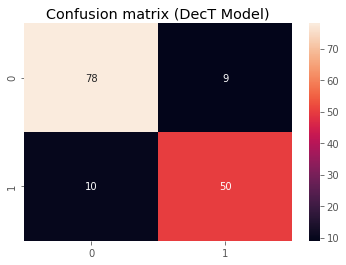

In [81]:
best_param_dect = study_dect.best_params
DecT = DecisionTreeClassifier(**best_param_dect,random_state=42).fit(x_train,y_train)
y_pred_dect = DecT.predict(x_test)
    

display_results(y_test, y_pred_dect, cm_title = "Confusion matrix (DecT Model)")

### SVC

In [82]:
# Creating an Objective Function

def objective_svm(trial):
    
    # Define hyperparameters
    param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
                'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}

    # Create and train the model
    svm = SVC(**param_svm,random_state=100)
    svm.fit(x_train_, y_train)

    # Evaluate the model
    score = cross_val_score(svm, x_train_, y_train, cv=cv, scoring="accuracy").mean()

    return score

In [83]:
# Creating and running our optimization

study_svm = optuna.create_study(direction='maximize',study_name ="SVM")
study_svm.optimize(objective_svm, n_trials=500)

[I 2023-08-25 01:22:11,158] A new study created in memory with name: SVM
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:22:11,695] Trial 0 finished with value: 0.7993278784336647 and parameters: {'C': 15.5072839218453, 'gamma': 0.00017981206815052462}. Best is trial 0 with value: 0.7993278784336647.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be remove

[I 2023-08-25 01:22:17,400] Trial 10 finished with value: 0.8068381063705435 and parameters: {'C': 899.5000555121318, 'gamma': 1.781320878508027e-05}. Best is trial 4 with value: 0.8327819988310928.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:22:17,869] Trial 11 finished with value: 0.8191233196960842 and parameters: {'C': 2.1596360653501683, 'gamma': 0.012839431598706649}. Best is trial 4 with value: 0.8327819988310928.


<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:22:25,478] Trial 21 finished with value: 0.8365283459964933 and parameters: {'C': 656.0028051510898, 'gamma': 0.00359242365205132}. Best is trial 14 with value: 0.837895967270602.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

[I 2023-08-25 01:22:32,917] Trial 31 finished with value: 0.8331268264172997 and parameters: {'C': 435.40968642755746, 'gamma': 0.003457930328733265}. Best is trial 22 with value: 0.8382349503214495.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:22:33,561] Trial 32 finished with value: 0.8310695499707773 and parameters: {'C': 130.34144100851105, 'gamma': 0.0026915078068060765}. Best is trial 22 with value: 0.838234950321449

<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:22:40,766] Trial 42 finished with value: 0.8365341905318527 and parameters: {'C': 445.45926600724334, 'gamma': 0.003950916579681406}. Best is trial 22 with value: 0.8382349503214495.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

[I 2023-08-25 01:22:52,082] Trial 52 finished with value: 0.8358270017533607 and parameters: {'C': 199.69036877177265, 'gamma': 0.006247521830936608}. Best is trial 22 with value: 0.8382349503214495.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:22:53,252] Trial 53 finished with value: 0.8358386908240795 and parameters: {'C': 931.2260092887084, 'gamma': 0.003074323438311728}. Best is trial 22 with value: 0.8382349503214495.

<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:23:06,879] Trial 63 finished with value: 0.8331385154880186 and parameters: {'C': 162.58180084440335, 'gamma': 0.008617796372090238}. Best is trial 57 with value: 0.8385856224430158.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

[I 2023-08-25 01:23:15,652] Trial 73 finished with value: 0.8337872589129164 and parameters: {'C': 10.040007511971918, 'gamma': 0.01374116365308878}. Best is trial 57 with value: 0.8385856224430158.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:23:16,497] Trial 74 finished with value: 0.8321098772647575 and parameters: {'C': 351.58735062237326, 'gamma': 0.006249104907613518}. Best is trial 57 with value: 0.8385856224430158.

<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:23:27,269] Trial 84 finished with value: 0.8375452951490355 and parameters: {'C': 362.8142413368927, 'gamma': 0.01703798221966111}. Best is trial 79 with value: 0.8395850379894799.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Us

[I 2023-08-25 01:23:37,852] Trial 94 finished with value: 0.8392460549386324 and parameters: {'C': 369.4548506478294, 'gamma': 0.015856897927000173}. Best is trial 79 with value: 0.8395850379894799.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:23:38,972] Trial 95 finished with value: 0.8321040327293978 and parameters: {'C': 592.462747144686, 'gamma': 0.005229894190108211}. Best is trial 79 with value: 0.8395850379894799.
<

<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:23:49,352] Trial 105 finished with value: 0.8365166569257744 and parameters: {'C': 97.08357782601782, 'gamma': 0.015461265354965222}. Best is trial 79 with value: 0.8395850379894799.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

[I 2023-08-25 01:23:59,682] Trial 115 finished with value: 0.8378784336645236 and parameters: {'C': 89.49177662806328, 'gamma': 0.0254311088333932}. Best is trial 107 with value: 0.840958503798948.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:24:00,463] Trial 116 finished with value: 0.8324313267095265 and parameters: {'C': 61.209229269445174, 'gamma': 0.0439768614034996}. Best is trial 107 with value: 0.840958503798948.
<

<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:24:09,245] Trial 126 finished with value: 0.8365341905318526 and parameters: {'C': 89.66996049497257, 'gamma': 0.014443530091267595}. Best is trial 107 with value: 0.840958503798948.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

[I 2023-08-25 01:24:18,748] Trial 136 finished with value: 0.8330917592051433 and parameters: {'C': 279.53873942328323, 'gamma': 0.010804807537059934}. Best is trial 107 with value: 0.840958503798948.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:24:19,289] Trial 137 finished with value: 0.8252834599649329 and parameters: {'C': 460.089039227881, 'gamma': 0.0010366018495807853}. Best is trial 107 with value: 0.84095850379894

<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:24:29,717] Trial 147 finished with value: 0.8331268264172997 and parameters: {'C': 102.03829698430262, 'gamma': 0.012702086074237465}. Best is trial 107 with value: 0.840958503798948.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0.

[I 2023-08-25 01:24:39,885] Trial 157 finished with value: 0.8348275862068966 and parameters: {'C': 107.36421279449208, 'gamma': 0.009347467075173966}. Best is trial 107 with value: 0.840958503798948.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:24:40,533] Trial 158 finished with value: 0.8378609000584454 and parameters: {'C': 63.42151474817928, 'gamma': 0.023146016628399015}. Best is trial 107 with value: 0.84095850379894

<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:24:49,210] Trial 168 finished with value: 0.8385563997662185 and parameters: {'C': 287.0878022470219, 'gamma': 0.0028102699230624635}. Best is trial 107 with value: 0.840958503798948.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0.

[I 2023-08-25 01:24:55,601] Trial 178 finished with value: 0.8010520163646991 and parameters: {'C': 1.532881521047921, 'gamma': 0.0020693892127120863}. Best is trial 107 with value: 0.840958503798948.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:24:56,078] Trial 179 finished with value: 0.6722852133255407 and parameters: {'C': 0.2842938728711633, 'gamma': 0.0015474960430423422}. Best is trial 107 with value: 0.840958503798

<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:25:02,329] Trial 189 finished with value: 0.8303974284044418 and parameters: {'C': 753.2252884665065, 'gamma': 0.006743898754608053}. Best is trial 107 with value: 0.840958503798948.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

[I 2023-08-25 01:25:13,600] Trial 199 finished with value: 0.8365458796025717 and parameters: {'C': 423.4653314053104, 'gamma': 0.01736043764148176}. Best is trial 107 with value: 0.840958503798948.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:25:14,721] Trial 200 finished with value: 0.8392577440093512 and parameters: {'C': 222.56229145194695, 'gamma': 0.01895119175111038}. Best is trial 107 with value: 0.840958503798948.

<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:25:23,718] Trial 210 finished with value: 0.8194564582115721 and parameters: {'C': 173.4215199760484, 'gamma': 0.03751441959896932}. Best is trial 107 with value: 0.840958503798948.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. U

[I 2023-08-25 01:25:33,102] Trial 220 finished with value: 0.8348217416715373 and parameters: {'C': 527.0905087029557, 'gamma': 0.018641603361973003}. Best is trial 107 with value: 0.840958503798948.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:25:33,550] Trial 221 finished with value: 0.8358386908240796 and parameters: {'C': 4.924828254061007, 'gamma': 0.021368342653515976}. Best is trial 107 with value: 0.840958503798948

<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:25:38,137] Trial 231 finished with value: 0.8341320864991233 and parameters: {'C': 19.54318449306493, 'gamma': 0.02552780211829918}. Best is trial 107 with value: 0.840958503798948.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. U

[I 2023-08-25 01:25:42,866] Trial 241 finished with value: 0.8354821741671539 and parameters: {'C': 13.192290446954505, 'gamma': 0.028339329994426527}. Best is trial 107 with value: 0.840958503798948.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:25:43,403] Trial 242 finished with value: 0.8402805376972531 and parameters: {'C': 25.43950041135121, 'gamma': 0.04067644847781047}. Best is trial 107 with value: 0.840958503798948

<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:25:48,930] Trial 252 finished with value: 0.8405902980713033 and parameters: {'C': 19.589401924711687, 'gamma': 0.042897090701515976}. Best is trial 249 with value: 0.8419579193454121.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0

[I 2023-08-25 01:25:54,431] Trial 262 finished with value: 0.8416481589713618 and parameters: {'C': 17.572438115718104, 'gamma': 0.03969161169207554}. Best is trial 253 with value: 0.8430040911747517.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:25:54,929] Trial 263 finished with value: 0.8423261250730567 and parameters: {'C': 15.349671632192386, 'gamma': 0.04244351490528612}. Best is trial 253 with value: 0.84300409117475

<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:25:59,945] Trial 273 finished with value: 0.8379135008766804 and parameters: {'C': 8.929630075964011, 'gamma': 0.07177436470078286}. Best is trial 264 with value: 0.8433489187609585.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

[I 2023-08-25 01:26:05,055] Trial 283 finished with value: 0.842302746931619 and parameters: {'C': 18.827436895059975, 'gamma': 0.042734404221595}. Best is trial 264 with value: 0.8433489187609585.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:26:05,656] Trial 284 finished with value: 0.8399357101110461 and parameters: {'C': 18.753970065341875, 'gamma': 0.04775798832048808}. Best is trial 264 with value: 0.8433489187609585.

<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:26:10,626] Trial 294 finished with value: 0.8402337814143778 and parameters: {'C': 9.649836584556558, 'gamma': 0.04424885151652987}. Best is trial 264 with value: 0.8433489187609585.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

[I 2023-08-25 01:26:15,238] Trial 304 finished with value: 0.8419462302746932 and parameters: {'C': 5.5487582159689675, 'gamma': 0.06331946087979805}. Best is trial 300 with value: 0.8447048509643484.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:26:15,708] Trial 305 finished with value: 0.823904149620105 and parameters: {'C': 5.765722834531302, 'gamma': 0.14514078912344125}. Best is trial 300 with value: 0.8447048509643484

<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:26:20,244] Trial 315 finished with value: 0.8396084161309176 and parameters: {'C': 7.851124294039992, 'gamma': 0.07373427162791432}. Best is trial 300 with value: 0.8447048509643484.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

[I 2023-08-25 01:26:24,839] Trial 325 finished with value: 0.8419812974868498 and parameters: {'C': 3.236518593337008, 'gamma': 0.11118517910786203}. Best is trial 323 with value: 0.8453828170660432.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:26:25,389] Trial 326 finished with value: 0.8419988310929282 and parameters: {'C': 3.783788472650772, 'gamma': 0.10963664130802957}. Best is trial 323 with value: 0.8453828170660432

<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:26:29,949] Trial 336 finished with value: 0.8429924021040328 and parameters: {'C': 2.00156227782953, 'gamma': 0.12248199175529216}. Best is trial 323 with value: 0.8453828170660432.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. U

[I 2023-08-25 01:26:34,568] Trial 346 finished with value: 0.8402980713033315 and parameters: {'C': 5.125297839722078, 'gamma': 0.09334234265139342}. Best is trial 323 with value: 0.8453828170660432.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:26:35,016] Trial 347 finished with value: 0.8409468147282291 and parameters: {'C': 1.6680566372645576, 'gamma': 0.13005980741532758}. Best is trial 323 with value: 0.845382817066043

<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:26:39,736] Trial 357 finished with value: 0.8419754529514902 and parameters: {'C': 2.6029852920509478, 'gamma': 0.12575093941872262}. Best is trial 323 with value: 0.8453828170660432.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0.

[I 2023-08-25 01:26:44,503] Trial 367 finished with value: 0.8385914669783752 and parameters: {'C': 4.922124563025722, 'gamma': 0.0990733173322372}. Best is trial 323 with value: 0.8453828170660432.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:26:44,965] Trial 368 finished with value: 0.8310870835768555 and parameters: {'C': 3.295737771398979, 'gamma': 0.16634267418556586}. Best is trial 323 with value: 0.8453828170660432.

<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:26:49,746] Trial 378 finished with value: 0.8447048509643483 and parameters: {'C': 6.9713174102982975, 'gamma': 0.06632050844237924}. Best is trial 323 with value: 0.8453828170660432.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0.

[I 2023-08-25 01:26:54,485] Trial 388 finished with value: 0.8338223261250731 and parameters: {'C': 8.458485371339986, 'gamma': 0.08322063369998667}. Best is trial 323 with value: 0.8453828170660432.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:26:54,961] Trial 389 finished with value: 0.6722852133255407 and parameters: {'C': 5.935095152607082, 'gamma': 2.868059996330816e-05}. Best is trial 323 with value: 0.84538281706604

<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:27:00,143] Trial 399 finished with value: 0.8426300409117476 and parameters: {'C': 6.6124094881289395, 'gamma': 0.05921252877496281}. Best is trial 323 with value: 0.8453828170660432.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0.

[I 2023-08-25 01:27:05,404] Trial 409 finished with value: 0.8422910578609 and parameters: {'C': 2.9524115057289055, 'gamma': 0.08704657129783169}. Best is trial 323 with value: 0.8453828170660432.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:27:05,927] Trial 410 finished with value: 0.8392226767971946 and parameters: {'C': 4.253465170631792, 'gamma': 0.06880615570373977}. Best is trial 323 with value: 0.8453828170660432.


<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:27:11,947] Trial 420 finished with value: 0.8338223261250731 and parameters: {'C': 7.438403530534761, 'gamma': 0.10008007252108658}. Best is trial 323 with value: 0.8453828170660432.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

[I 2023-08-25 01:27:17,136] Trial 430 finished with value: 0.8381998831092929 and parameters: {'C': 3.411638479626526, 'gamma': 0.07502740491997535}. Best is trial 323 with value: 0.8453828170660432.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:27:17,548] Trial 431 finished with value: 0.8303915838690823 and parameters: {'C': 0.5002465206090907, 'gamma': 0.054780373787263595}. Best is trial 323 with value: 0.84538281706604

<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:27:22,441] Trial 441 finished with value: 0.8446814728229106 and parameters: {'C': 3.7229853158218873, 'gamma': 0.09532716630474693}. Best is trial 323 with value: 0.8453828170660432.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0.

[I 2023-08-25 01:27:27,479] Trial 451 finished with value: 0.6722852133255407 and parameters: {'C': 0.018845225028183223, 'gamma': 0.47819292878061254}. Best is trial 323 with value: 0.8453828170660432.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:27:28,101] Trial 452 finished with value: 0.8149970777323203 and parameters: {'C': 8.445011103096014, 'gamma': 0.2626419590277248}. Best is trial 323 with value: 0.84538281706604

<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:27:33,030] Trial 462 finished with value: 0.8440151957919346 and parameters: {'C': 8.925079822537109, 'gamma': 0.052620815714655}. Best is trial 323 with value: 0.8453828170660432.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Us

[I 2023-08-25 01:27:37,689] Trial 472 finished with value: 0.8433372296902397 and parameters: {'C': 6.140704469517463, 'gamma': 0.06991428458210898}. Best is trial 323 with value: 0.8453828170660432.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:27:38,375] Trial 473 finished with value: 0.8136703682057277 and parameters: {'C': 12.304572930211407, 'gamma': 0.3764285263121181}. Best is trial 323 with value: 0.8453828170660432

<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:27:43,391] Trial 483 finished with value: 0.8416481589713619 and parameters: {'C': 5.540958112412358, 'gamma': 0.08367422506124134}. Best is trial 323 with value: 0.8453828170660432.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

[I 2023-08-25 01:27:48,411] Trial 493 finished with value: 0.8112682641729982 and parameters: {'C': 6.25208553302381, 'gamma': 0.549856931401513}. Best is trial 323 with value: 0.8453828170660432.
<ipython-input-82-d6c1525755d4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-82-d6c1525755d4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0)}
[I 2023-08-25 01:27:48,884] Trial 494 finished with value: 0.800374050263004 and parameters: {'C': 4.812366226571311, 'gamma': 0.0007819086353738676}. Best is trial 323 with value: 0.8453828170660432.


In [84]:
# Evaluating our Optuna Trial
print("Best trial:", study_svm.best_trial.number)
print("Best accuracy:", study_svm.best_trial.value)
print("Best hyperparameters:", study_svm.best_params)

Best trial: 323
Best accuracy: 0.8453828170660432
Best hyperparameters: {'C': 3.3878952026910505, 'gamma': 0.09544681557293193}


              precision    recall  f1-score   support

           0       0.75      0.91      0.82        87
           1       0.81      0.57      0.67        60

    accuracy                           0.77       147
   macro avg       0.78      0.74      0.74       147
weighted avg       0.78      0.77      0.76       147



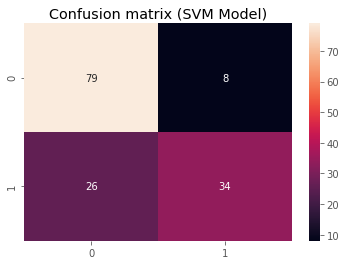

In [85]:
best_param_svm = study_svm.best_params
SVM = SVC(**best_param_svm,random_state=100).fit(x_train_,y_train)
y_pred_svm = SVM.predict(x_test_)

    
display_results(y_test, y_pred_svm, cm_title = "Confusion matrix (SVM Model)")

## Models comparision using ROC- Curve plot

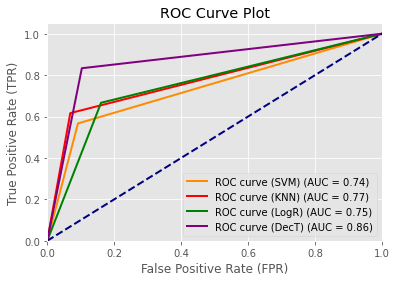

In [86]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_svm)
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred_knn)
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_pred_lr)
fpr4, tpr4, thresholds3 = roc_curve(y_test, y_pred_dect)

# calculate area under curve (AUC)
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)

# plot ROC curve
plt.figure()
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label=f'ROC curve (SVM) (AUC = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, color='red', lw=2, label=f'ROC curve (KNN) (AUC = {roc_auc2:.2f})')
plt.plot(fpr3, tpr3, color='green', lw=2, label=f'ROC curve (LogR) (AUC = {roc_auc3:.2f})')
plt.plot(fpr4, tpr4, color='purple', lw=2, label=f'ROC curve (DecT) (AUC = {roc_auc4:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title("ROC Curve Plot")
plt.legend(loc="lower right")
plt.show()

In [87]:
def evaluate_model(y_true, y_pred, model_name):
    accuracy = round(accuracy_score(y_test, y_pred),3)
    recall = round(recall_score(y_test, y_pred, pos_label=1),3)
    return pd.Series([accuracy, recall], index=['Accuracy', 'Recall'], name=model_name)

# Evaluate metrics
knn_metrics = evaluate_model(y_test, y_pred_knn, 'KNN')
svm_metrics = evaluate_model(y_test, y_pred_svm, 'SVM')
lr_metrics = evaluate_model(y_test, y_pred_lr, 'LR')
dect_metrics = evaluate_model(y_test, y_pred_dect, 'DecT')


# Create DataFrame with model names as columns and metrics as rows
metrics_df = pd.DataFrame([knn_metrics, svm_metrics,lr_metrics,dect_metrics])

metrics_df

Accuracy  Recall
KNN      0.803   0.617
SVM      0.769   0.567
LR       0.769   0.667
DecT     0.871   0.833

## Conclusion

Without parameter tuning, ensemble models and modified boosting classifiers (AdaBoost and RFC) perform well (AUC = 0.85). After hyperparameter tuning, even a simple Decision Tree classifier works better than both AdaBoost and Random Forest Classifier (AUC = 0.86). In addition to that, the tuned Decision Tree model also has better and improved accuracy and recall which are very important in case of disease classification.